# Expore data

## Import & definitions

In [1]:
import os
import sys
from pathlib import Path
import re
import random
import time
import math
from datetime import timedelta
from datetime import timezone
from datetime import datetime
import json
import joblib
# Third Party
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
# from helpers.ocean_helpers import save_list
'''import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from keras.regularizers import L1L2'''
# PLOT
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set_theme()

# definitions
PAST_HISTORY = int(60 / 5) * 6 #  6 hours in 5mins units : used to predict next values in future
FUTURE_TARGET = 12 + 3 # number of 5 min to predict  : 15
STEP = 1
BATCH_SIZE = 256 #128 #32
TRAIN_SPLIT_RATIO = 0.995 #0.8 #0.9891 # 1-(60/5*24)/50977

MODE_TRAIN_AE = True 
'''
#LIST_SEEDS = [1,2,3,4,5]
LIST_SEEDS = [1]
MODE_AUTO_SELECT = 0 #1 #   #0 # 0: False, 1: True, 2: from disk
MODE_TRAIN_PREDICTOR = True # False

EPOCHS_AE = 1#30
PATIENCE_AE = 0#10
LIST_UNITS_ENC_AE = [64]
LIST_UNITS_AE = [16]
LIST_DROPOUT_AE = [0.2]

EPOCHS_PRED = 100#30
PATIENCE_PRED = 0#10
LIST_UNITS_PRED = [128]
LIST_DROPOUT_PRED = [0.2]

MODE_TRAIN_LSTM = False
'''
# paths
path_data = "data"
path_save_df_feat = os.path.join(path_data, "df_features_05m.csv")

path_save_pred_vals = os.path.join(path_data, "pred_vals.csv")
path_save_auto_select = os.path.join(path_data, "list_auto_select.csv")

path_scaler = os.path.join(path_data, "scaler.bin")
path_scaler_y = os.path.join(path_data, "scaler_y.bin")
path_scaler_enc = os.path.join(path_data, "scaler_enc.bin")
path_save_df_feat_std = os.path.join(path_data, "df_features_05m_std.csv")
'''
path_mdl_autoencoder =  os.path.join(path_data, "mdl_autoencoder")
path_mdl_encoder  =  os.path.join(path_data, "mdl_encoder")
path_mdl_predict_lstm  =  os.path.join(path_data, "mdl_predict_lstm")
path_mdl_predict_autoenc_lstm  =  os.path.join(
    path_data, "mdl_predict_autoenc_lstm")
'''

'\npath_mdl_autoencoder =  os.path.join(path_data, "mdl_autoencoder")\npath_mdl_encoder  =  os.path.join(path_data, "mdl_encoder")\npath_mdl_predict_lstm  =  os.path.join(path_data, "mdl_predict_lstm")\npath_mdl_predict_autoenc_lstm  =  os.path.join(\n    path_data, "mdl_predict_autoenc_lstm")\n'

In [2]:
PAST_HISTORY

72

In [3]:
print(60/5*24*2)
1-(60/5*24*2)/52981

576.0


0.9891281780260848

In [4]:
# helpers: save/load list
def save_list(list_: list, file_name: str):
    """Save a file shaped: [1.2, 3.4, 5.6, ..]"""
    p = Path(file_name)
    p.write_text(str(list_))
    
def load_list(file_name: str) -> list:
    """Load from a file shaped: [1.2, 3.4, 5.6, ..]"""
    p = Path(file_name)
    s = p.read_text()
    list_ = eval(s)
    return list_

In [5]:
def plot_train_history(history, title, saveFolder=None):
    """
    Plot train errors
    """
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    fig = plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()
    ax = fig.gca()
    ax.set_xlabel("epoch[-]")
    if saveFolder is not None:
        title_clean = re.sub('[^-a-zA-Z0-9 \.]', ' ', title)
        plt.savefig(os.path.join(saveFolder, f"output_{title_clean}.jpg")) 
    plt.show()


def naming_plot(n_unit_enc, encoding_dim, dropout_autoenc):
    return f"TS {TRAIN_SPLIT_RATIO} - units {n_unit_enc} - enc_dim {encoding_dim} - drop {dropout_autoenc}"

## Load raw features

In [6]:
# load
df_feat_raw = pd.read_csv(path_save_df_feat)
df_feat_raw

/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_125/3998402900.py:2: DtypeWarning: Columns (118,119,120,121,122,123,124,134) have mixed types. Specify dtype option on import or set low_memory=False.
  df_feat_raw = pd.read_csv(path_save_df_feat)


,Time,Open_ETH,High_ETH,Low_ETH,Close_ETH,Volume_ETH,date_ETH,ichi_cloud_a_ETH,ichi_cloud_b_ETH,ichi_kijun_ETH,...,keep,Actual_num,Consensus_num,Previous_num,delta_event_pred,event_pred,delta_event_real,event_real,day_off,date
0,1672531200000,1196.13,1196.32,1195.65,1196.32,334.5592,2023-01-01 00:00:00,1729.626872,1729.19975,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN
1,1672531500000,1196.31,1196.69,1194.90,1195.38,682.3876,2023-01-01 00:05:00,1729.626872,1729.19975,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN
2,1672531800000,1195.38,1195.81,1194.55,1194.55,228.9387,2023-01-01 00:10:00,1729.626872,1729.19975,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN
3,1672532100000,1194.55,1195.98,1194.31,1195.98,601.8903,2023-01-01 00:15:00,1729.626872,1729.19975,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN
4,1672532400000,1195.98,1196.37,1195.97,1196.06,144.8048,2023-01-01 00:20:00,1729.626872,1729.19975,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89547,1699395300000,1881.27,1881.27,1876.42,1876.43,1684.9929,2023-11-07 22:15:00,1890.450000,1875.16000,1891.705,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN
89548,1699395600000,1876.43,1877.28,1872.72,1877.03,3565.2079,2023-11-07 22:20:00,1891.052500,1875.16000,1889.855,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN
89549,1699395900000,1877.02,1881.81,1876.94,1880.35,1453.3867,2023-11-07 22:25:00,1893.500000,1875.16000,1889.855,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN
89550,1699396200000,1880.35,1880.70,1877.50,1879.23,909.3287,2023-11-07 22:30:00,1893.500000,1875.16000,1889.855,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN


### drop nan

In [7]:
def get_missing(df):
    nb_missing = df.isnull().sum()
    nb_missing = nb_missing.sort_values()
    nb_missing = nb_missing[nb_missing.values > 0]
    print("missing data : ")
    print(nb_missing)
    print("")
    print("on {} samples".format(df.shape[0]))
    return nb_missing

nb_missing = get_missing(df_feat_raw)

missing data : 
vwap_z_score_ETH        1
vwap_z_score_BTC        1
ichi_tenkan_ETH         8
ichi_tenkan_BTC         8
rsi_h_ETH              13
                    ...  
Actual              89514
Event               89514
Country             89514
keep                89514
date                89514
Length: 65, dtype: int64

on 89552 samples


#### Cheat Backward Filling

In [8]:
df_feat = df_feat_raw.copy()

In [9]:
df_feat = df_feat.bfill(axis ='rows')

In [10]:
df_feat

,Time,Open_ETH,High_ETH,Low_ETH,Close_ETH,Volume_ETH,date_ETH,ichi_cloud_a_ETH,ichi_cloud_b_ETH,ichi_kijun_ETH,...,keep,Actual_num,Consensus_num,Previous_num,delta_event_pred,event_pred,delta_event_real,event_real,day_off,date
0,1672531200000,1196.13,1196.32,1195.65,1196.32,334.5592,2023-01-01 00:00:00,1729.626872,1729.19975,1194.710,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2023-01-02 05:00:00
1,1672531500000,1196.31,1196.69,1194.90,1195.38,682.3876,2023-01-01 00:05:00,1729.626872,1729.19975,1194.710,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2023-01-02 05:00:00
2,1672531800000,1195.38,1195.81,1194.55,1194.55,228.9387,2023-01-01 00:10:00,1729.626872,1729.19975,1194.710,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2023-01-02 05:00:00
3,1672532100000,1194.55,1195.98,1194.31,1195.98,601.8903,2023-01-01 00:15:00,1729.626872,1729.19975,1194.710,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2023-01-02 05:00:00
4,1672532400000,1195.98,1196.37,1195.97,1196.06,144.8048,2023-01-01 00:20:00,1729.626872,1729.19975,1194.710,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2023-01-02 05:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89547,1699395300000,1881.27,1881.27,1876.42,1876.43,1684.9929,2023-11-07 22:15:00,1890.450000,1875.16000,1891.705,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN
89548,1699395600000,1876.43,1877.28,1872.72,1877.03,3565.2079,2023-11-07 22:20:00,1891.052500,1875.16000,1889.855,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN
89549,1699395900000,1877.02,1881.81,1876.94,1880.35,1453.3867,2023-11-07 22:25:00,1893.500000,1875.16000,1889.855,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN
89550,1699396200000,1880.35,1880.70,1877.50,1879.23,909.3287,2023-11-07 22:30:00,1893.500000,1875.16000,1889.855,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN


In [11]:
nb_missing = get_missing(df_feat)

missing data : 
Consensus_num       1483
delta_event_real    1483
delta_event_pred    1483
Previous_num        1483
Actual_num          1483
Event               1483
Date                1483
Previous            1483
Consensus           1483
Actual              1483
Country             1483
Time (ET)           1483
keep                1483
date                1483
dtype: int64

on 89552 samples


In [12]:
#print(df_feat.shape)
#df_feat = df_feat.dropna(subset=["Consensus_num"]).copy()
#df_feat.reset_index(inplace=True)
#df_feat.shape

## Features Selection

### Proportional to the Price

In [13]:
list_col = df_feat.columns.to_list()
list_col

['Time',
 'Open_ETH',
 'High_ETH',
 'Low_ETH',
 'Close_ETH',
 'Volume_ETH',
 'date_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'rsi_h_ETH',
 'rsi_d_ETH',
 'rsi_w_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'atr_h_ETH',
 'chop_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'atr_d_ETH',
 'chop_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'atr_w_ETH',
 'chop_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'vwap_z_score_ETH',
 'nupl_ETH',
 'fear_greed',
 'fear_greed_class',
 'fvx',
 'spx',
 'dxy',
 'supply_ETH',
 'act_addr_ETH',
 'market_dom_ETH',
 'hour',
 'hour_cos',
 'hour_sin',
 'weekday',
 'weekday_cos',
 'weekday_sin',
 'day',
 'days_in_month',
 'day_ratio',
 'da

In [14]:
list_col_ETH = [col for col in list_col if re.search("_ETH", col) is not None]
list_col_ETH

['Open_ETH',
 'High_ETH',
 'Low_ETH',
 'Close_ETH',
 'Volume_ETH',
 'date_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'rsi_h_ETH',
 'rsi_d_ETH',
 'rsi_w_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'atr_h_ETH',
 'chop_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'atr_d_ETH',
 'chop_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'atr_w_ETH',
 'chop_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'vwap_z_score_ETH',
 'nupl_ETH',
 'supply_ETH',
 'act_addr_ETH',
 'market_dom_ETH']

In [15]:
df_feat[list_col_ETH]

,Open_ETH,High_ETH,Low_ETH,Close_ETH,Volume_ETH,date_ETH,ichi_cloud_a_ETH,ichi_cloud_b_ETH,ichi_kijun_ETH,ichi_tenkan_ETH,...,vwap_m_ETH,vwap_3m_ETH,vwap_6m_ETH,vwap_y_ETH,vwap_all_ETH,vwap_z_score_ETH,nupl_ETH,supply_ETH,act_addr_ETH,market_dom_ETH
0,1196.13,1196.32,1195.65,1196.32,334.5592,2023-01-01 00:00:00,1729.626872,1729.19975,1194.710,1194.710,...,1196.096667,1196.096667,1196.096667,1196.096667,1196.096667,-0.634018,0.000187,1.204830e+08,569008.0,17.688457
1,1196.31,1196.69,1194.90,1195.38,682.3876,2023-01-01 00:05:00,1729.626872,1729.19975,1194.710,1194.710,...,1195.801420,1195.801420,1195.801420,1195.801420,1195.801420,-0.634018,-0.000353,1.204830e+08,569008.0,17.688457
2,1195.38,1195.81,1194.55,1194.55,228.9387,2023-01-01 00:10:00,1729.626872,1729.19975,1194.710,1194.710,...,1195.648641,1195.648641,1195.648641,1195.648641,1195.648641,-1.240604,-0.000920,1.204830e+08,569008.0,17.688457
3,1194.55,1195.98,1194.31,1195.98,601.8903,2023-01-01 00:15:00,1729.626872,1729.19975,1194.710,1194.710,...,1195.575250,1195.575250,1195.575250,1195.575250,1195.575250,0.521593,0.000338,1.204830e+08,569008.0,17.688457
4,1195.98,1196.37,1195.97,1196.06,144.8048,2023-01-01 00:20:00,1729.626872,1729.19975,1194.710,1194.710,...,1195.615807,1195.615807,1195.615807,1195.615807,1195.615807,0.626856,0.000371,1.204830e+08,569008.0,17.688457
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89547,1881.27,1881.27,1876.42,1876.43,1684.9929,2023-11-07 22:15:00,1890.450000,1875.16000,1891.705,1886.980,...,1799.934922,1695.655459,1704.727026,1724.250372,1723.780632,0.940088,0.081351,1.202659e+08,425121.0,16.572813
89548,1876.43,1877.28,1872.72,1877.03,3565.2079,2023-11-07 22:20:00,1891.052500,1875.16000,1889.855,1885.130,...,1799.996252,1695.704589,1704.748190,1724.334045,1723.785337,0.943755,0.081642,1.202659e+08,425121.0,16.572813
89549,1877.02,1881.81,1876.94,1880.35,1453.3867,2023-11-07 22:25:00,1893.500000,1875.16000,1889.855,1884.215,...,1800.022357,1695.726041,1704.755645,1724.366036,1723.787306,0.964190,0.083263,1.202659e+08,425121.0,16.572813
89550,1880.35,1880.70,1877.50,1879.23,909.3287,2023-11-07 22:30:00,1893.500000,1875.16000,1889.855,1883.600,...,1800.044662,1695.739532,1704.760539,1724.388134,1723.788533,0.957285,0.082716,1.202659e+08,425121.0,16.572813


In [16]:
list_price_dep_ETH = [
    "Close_ETH",
    "Open_ETH",
    "High_ETH",
    "Low_ETH",
    'ichi_cloud_a_ETH',
    'ichi_cloud_b_ETH',
    'ichi_kijun_ETH',
    'ichi_tenkan_ETH',
    'ichi_cloud_a_day_ETH',
    'ichi_cloud_b_day_ETH',
    'ichi_kijun_day_ETH',
    'ichi_tenkan_day_ETH',
    'ichi_cloud_a_week_ETH',
    'ichi_cloud_b_week_ETH',
    'ichi_kijun_week_ETH',
    'ichi_tenkan_week_ETH',
    'max_high_h_ETH',
    'min_low_h_ETH',
    'max_high_d_ETH',
    'min_low_d_ETH',
    'max_high_w_ETH',
    'min_low_w_ETH',
    'vwap_h_ETH',
    'vwap_d_ETH',
    'vwap_w_ETH',
    'vwap_m_ETH',
    'vwap_3m_ETH',
    'vwap_6m_ETH',
    'vwap_y_ETH',
    'vwap_all_ETH',
]


#    'max_high_h_ETH',
#    'ichi_tenkan_week_ETH',

In [17]:
list_col_BTC = [col for col in list_col if re.search("_BTC", col) is not None]
list_col_BTC

['Open_BTC',
 'High_BTC',
 'Low_BTC',
 'Close_BTC',
 'Volume_BTC',
 'date_BTC',
 'ichi_cloud_a_BTC',
 'ichi_cloud_b_BTC',
 'ichi_kijun_BTC',
 'ichi_tenkan_BTC',
 'ichi_cloud_a_day_BTC',
 'ichi_cloud_b_day_BTC',
 'ichi_kijun_day_BTC',
 'ichi_tenkan_day_BTC',
 'ichi_cloud_a_week_BTC',
 'ichi_cloud_b_week_BTC',
 'ichi_kijun_week_BTC',
 'ichi_tenkan_week_BTC',
 'rsi_h_BTC',
 'rsi_d_BTC',
 'rsi_w_BTC',
 'max_high_h_BTC',
 'min_low_h_BTC',
 'atr_h_BTC',
 'chop_h_BTC',
 'max_high_d_BTC',
 'min_low_d_BTC',
 'atr_d_BTC',
 'chop_d_BTC',
 'max_high_w_BTC',
 'min_low_w_BTC',
 'atr_w_BTC',
 'chop_w_BTC',
 'vwap_h_BTC',
 'vwap_d_BTC',
 'vwap_w_BTC',
 'vwap_m_BTC',
 'vwap_3m_BTC',
 'vwap_6m_BTC',
 'vwap_y_BTC',
 'vwap_all_BTC',
 'vwap_z_score_BTC',
 'nupl_BTC',
 'supply_BTC',
 'act_addr_BTC',
 'market_dom_BTC']

In [18]:
list_price_dep_BTC = [
    'Open_BTC',
    'High_BTC',
    'Low_BTC',
    'Close_BTC',
    'ichi_cloud_a_BTC',
    'ichi_cloud_b_BTC',
    'ichi_kijun_BTC',
    'ichi_tenkan_BTC',
    'ichi_cloud_a_day_BTC',
    'ichi_cloud_b_day_BTC',
    'ichi_kijun_day_BTC',
    'ichi_tenkan_day_BTC',
    'ichi_cloud_a_week_BTC',
    'ichi_cloud_b_week_BTC',
    'ichi_kijun_week_BTC',
    'ichi_tenkan_week_BTC',
    'max_high_h_BTC',
    'min_low_h_BTC',
    'max_high_d_BTC',
    'min_low_d_BTC',
    'max_high_w_BTC',
    'min_low_w_BTC',
    'vwap_h_BTC',
    'vwap_d_BTC',
    'vwap_w_BTC',
    'vwap_m_BTC',
    'vwap_3m_BTC',
    'vwap_6m_BTC',
    'vwap_y_BTC',
    'vwap_all_BTC',
    'vwap_z_score_BTC',
]

In [19]:
list_col_BNB = [col for col in list_col if re.search("_BNB", col) is not None]
list_col_BNB

['Open_BNB', 'High_BNB', 'Low_BNB', 'Close_BNB', 'Volume_BNB', 'date_BNB']

In [20]:
list_price_dep_BNB = ['Open_BNB', 'High_BNB', 'Low_BNB', 'Close_BNB']

#### add special indices

In [21]:
df_feat[["fvx", "spx", "dxy"]]

,fvx,spx,dxy
0,3.910,3823.179932,103.494003
1,3.910,3823.179932,103.494003
2,3.910,3823.179932,103.494003
3,3.910,3823.179932,103.494003
4,3.910,3823.179932,103.494003
...,...,...,...
89547,4.538,4378.379883,105.504997
89548,4.538,4378.379883,105.504997
89549,4.538,4378.379883,105.504997
89550,4.538,4378.379883,105.504997


In [22]:
list_price_dep_special = ["fvx", "spx", "dxy"]

### Not proportional to the Price 

In [23]:
set(list_col) - set(list_price_dep_ETH) - set(list_price_dep_BTC) - set(list_price_dep_BNB) - set(list_price_dep_special)

{'Actual',
 'Actual_num',
 'Consensus',
 'Consensus_num',
 'Country',
 'Date',
 'Event',
 'Previous',
 'Previous_num',
 'Time',
 'Time (ET)',
 'Volume_BNB',
 'Volume_BTC',
 'Volume_ETH',
 'act_addr_BTC',
 'act_addr_ETH',
 'atr_d_BTC',
 'atr_d_ETH',
 'atr_h_BTC',
 'atr_h_ETH',
 'atr_w_BTC',
 'atr_w_ETH',
 'chop_d_BTC',
 'chop_d_ETH',
 'chop_h_BTC',
 'chop_h_ETH',
 'chop_w_BTC',
 'chop_w_ETH',
 'date',
 'date_BNB',
 'date_BTC',
 'date_ETH',
 'day',
 'day_in_month_cos',
 'day_in_month_sin',
 'day_off',
 'day_ratio',
 'days_in_month',
 'delta_event_pred',
 'delta_event_real',
 'event_pred',
 'event_real',
 'fear_greed',
 'fear_greed_class',
 'hour',
 'hour_cos',
 'hour_sin',
 'keep',
 'market_dom_BTC',
 'market_dom_ETH',
 'month',
 'month_cos',
 'month_sin',
 'nupl_BTC',
 'nupl_ETH',
 'rsi_d_BTC',
 'rsi_d_ETH',
 'rsi_h_BTC',
 'rsi_h_ETH',
 'rsi_w_BTC',
 'rsi_w_ETH',
 'supply_BTC',
 'supply_ETH',
 'vwap_z_score_ETH',
 'weekday',
 'weekday_cos',
 'weekday_sin'}

In [24]:
list_col_other = [
    'Volume_BNB',
    'Volume_BTC',
    'Volume_ETH',
    'chop_d_BTC',
    'chop_d_ETH',
    'chop_h_BTC',
    'chop_h_ETH',
    'chop_w_BTC',
    'chop_w_ETH',
    'rsi_d_BTC',
    'rsi_d_ETH',
    'rsi_h_BTC',
    'rsi_h_ETH',
    'rsi_w_BTC',
    'rsi_w_ETH',
    'vwap_z_score_ETH',
    #'dxy',
    #'spx',
    #'fvx',
    'act_addr_BTC',
    'act_addr_ETH',
    'market_dom_BTC',
    'market_dom_ETH',
    'nupl_BTC',
    'nupl_ETH',
    'fear_greed',
    'supply_BTC',
    'supply_ETH',
    'hour_cos',
    'hour_sin',
    'weekday_cos',
    'weekday_sin',
    'day_in_month_cos',
    'day_in_month_sin',
    #'month_cos',
    #'month_sin',
    'day_off',
    'event_pred',
    'event_real',
]

### Final selection

In [25]:
list_col_select_simple = [
    "Close_ETH",
    "Open_ETH",
    "High_ETH",
    "Low_ETH",
]

list_col_select_global = (
    list_price_dep_ETH +
    list_price_dep_BTC +
    list_price_dep_BNB +  
    list_price_dep_special +  
    list_col_other
)


# selection
list_col_select = list_col_select_global

# only col in df_feat
list_col_select = [feat for feat in list_col_select if feat in df_feat.columns]
print("num features : ", len(list_col_select))

num features :  102


In [26]:
list_col_select

['Close_ETH',
 'Open_ETH',
 'High_ETH',
 'Low_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'Open_BTC',
 'High_BTC',
 'Low_BTC',
 'Close_BTC',
 'ichi_cloud_a_BTC',
 'ichi_cloud_b_BTC',
 'ichi_kijun_BTC',
 'ichi_tenkan_BTC',
 'ichi_cloud_a_day_BTC',
 'ichi_cloud_b_day_BTC',
 'ichi_kijun_day_BTC',
 'ichi_tenkan_day_BTC',
 'ichi_cloud_a_week_BTC',
 'ichi_cloud_b_week_BTC',
 'ichi_kijun_week_BTC',
 'ichi_tenkan_week_BTC',
 'max_high_h_BTC',
 'min_low_h_BTC',
 'max_high_d_BTC',
 'min_low_d_BTC',
 'max_high_w_BTC',
 'min_low_

## Features preparation

df_feat [selected features]   
--> X_train_raw, X_test_raw, y_train_raw, y_test_raw  
--> X_train (with prices ratio of ETH Close price at last lag) <-- used by autoencoder 


X [nb samples, nb lags, nb features]


In [27]:
df_feat.shape[0]

89552

In [28]:
TRAIN_SPLIT = round(TRAIN_SPLIT_RATIO * df_feat.shape[0])
TRAIN_SPLIT

89104

In [29]:
bol_train = [True if I <= TRAIN_SPLIT else False \
                       for I in range(df_feat.shape[0])]
df_feat["train"] = bol_train
df_feat

,Time,Open_ETH,High_ETH,Low_ETH,Close_ETH,Volume_ETH,date_ETH,ichi_cloud_a_ETH,ichi_cloud_b_ETH,ichi_kijun_ETH,...,Actual_num,Consensus_num,Previous_num,delta_event_pred,event_pred,delta_event_real,event_real,day_off,date,train
0,1672531200000,1196.13,1196.32,1195.65,1196.32,334.5592,2023-01-01 00:00:00,1729.626872,1729.19975,1194.710,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2023-01-02 05:00:00,True
1,1672531500000,1196.31,1196.69,1194.90,1195.38,682.3876,2023-01-01 00:05:00,1729.626872,1729.19975,1194.710,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2023-01-02 05:00:00,True
2,1672531800000,1195.38,1195.81,1194.55,1194.55,228.9387,2023-01-01 00:10:00,1729.626872,1729.19975,1194.710,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2023-01-02 05:00:00,True
3,1672532100000,1194.55,1195.98,1194.31,1195.98,601.8903,2023-01-01 00:15:00,1729.626872,1729.19975,1194.710,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2023-01-02 05:00:00,True
4,1672532400000,1195.98,1196.37,1195.97,1196.06,144.8048,2023-01-01 00:20:00,1729.626872,1729.19975,1194.710,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2023-01-02 05:00:00,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89547,1699395300000,1881.27,1881.27,1876.42,1876.43,1684.9929,2023-11-07 22:15:00,1890.450000,1875.16000,1891.705,...,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,False
89548,1699395600000,1876.43,1877.28,1872.72,1877.03,3565.2079,2023-11-07 22:20:00,1891.052500,1875.16000,1889.855,...,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,False
89549,1699395900000,1877.02,1881.81,1876.94,1880.35,1453.3867,2023-11-07 22:25:00,1893.500000,1875.16000,1889.855,...,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,False
89550,1699396200000,1880.35,1880.70,1877.50,1879.23,909.3287,2023-11-07 22:30:00,1893.500000,1875.16000,1889.855,...,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,False


In [30]:
df_feat[df_feat["train"] == True]

,Time,Open_ETH,High_ETH,Low_ETH,Close_ETH,Volume_ETH,date_ETH,ichi_cloud_a_ETH,ichi_cloud_b_ETH,ichi_kijun_ETH,...,Actual_num,Consensus_num,Previous_num,delta_event_pred,event_pred,delta_event_real,event_real,day_off,date,train
0,1672531200000,1196.13,1196.32,1195.65,1196.32,334.5592,2023-01-01 00:00:00,1729.626872,1729.19975,1194.710,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2023-01-02 05:00:00,True
1,1672531500000,1196.31,1196.69,1194.90,1195.38,682.3876,2023-01-01 00:05:00,1729.626872,1729.19975,1194.710,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2023-01-02 05:00:00,True
2,1672531800000,1195.38,1195.81,1194.55,1194.55,228.9387,2023-01-01 00:10:00,1729.626872,1729.19975,1194.710,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2023-01-02 05:00:00,True
3,1672532100000,1194.55,1195.98,1194.31,1195.98,601.8903,2023-01-01 00:15:00,1729.626872,1729.19975,1194.710,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2023-01-02 05:00:00,True
4,1672532400000,1195.98,1196.37,1195.97,1196.06,144.8048,2023-01-01 00:20:00,1729.626872,1729.19975,1194.710,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2023-01-02 05:00:00,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89100,1699261200000,1884.97,1885.71,1882.92,1884.62,1096.7809,2023-11-06 09:00:00,1875.907500,1879.16000,1879.435,...,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,True
89101,1699261500000,1884.63,1886.47,1883.63,1885.83,845.3860,2023-11-06 09:05:00,1875.907500,1879.16000,1879.795,...,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,True
89102,1699261800000,1885.84,1889.21,1885.76,1888.16,643.2491,2023-11-06 09:10:00,1876.460000,1879.16000,1881.165,...,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,True
89103,1699262100000,1888.15,1889.00,1884.59,1885.33,721.2269,2023-11-06 09:15:00,1876.610000,1879.16000,1881.165,...,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,True


In [31]:
df_feat[df_feat["train"] == False]

,Time,Open_ETH,High_ETH,Low_ETH,Close_ETH,Volume_ETH,date_ETH,ichi_cloud_a_ETH,ichi_cloud_b_ETH,ichi_kijun_ETH,...,Actual_num,Consensus_num,Previous_num,delta_event_pred,event_pred,delta_event_real,event_real,day_off,date,train
89105,1699262700000,1884.82,1885.94,1884.60,1884.85,560.2605,2023-11-06 09:25:00,1877.2675,1879.16,1881.165,...,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,False
89106,1699263000000,1884.85,1889.24,1884.84,1889.04,1124.8515,2023-11-06 09:30:00,1876.7375,1879.16,1881.180,...,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,False
89107,1699263300000,1889.03,1889.04,1886.87,1886.87,545.5007,2023-11-06 09:35:00,1876.0900,1879.16,1881.180,...,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,False
89108,1699263600000,1886.88,1889.10,1886.32,1888.98,599.0343,2023-11-06 09:40:00,1876.0300,1879.16,1881.180,...,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,False
89109,1699263900000,1888.98,1889.90,1886.57,1888.02,828.5194,2023-11-06 09:45:00,1876.1875,1879.16,1881.510,...,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89547,1699395300000,1881.27,1881.27,1876.42,1876.43,1684.9929,2023-11-07 22:15:00,1890.4500,1875.16,1891.705,...,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,False
89548,1699395600000,1876.43,1877.28,1872.72,1877.03,3565.2079,2023-11-07 22:20:00,1891.0525,1875.16,1889.855,...,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,False
89549,1699395900000,1877.02,1881.81,1876.94,1880.35,1453.3867,2023-11-07 22:25:00,1893.5000,1875.16,1889.855,...,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,False
89550,1699396200000,1880.35,1880.70,1877.50,1879.23,909.3287,2023-11-07 22:30:00,1893.5000,1875.16,1889.855,...,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,False


In [32]:
def gen_sequence(id_df, seq_length, len_pred, seq_cols, i_price_dep=None):

    data_matrix = id_df[seq_cols].values # data of selected col
    num_elements = data_matrix.shape[0] # nb samples

    for start, stop in zip(
            range(0, num_elements - seq_length - len_pred), 
            range(seq_length, num_elements - len_pred)
        ):
            out_matrix = data_matrix[start:stop, :].copy()
            if i_price_dep is not None:
                out_matrix[:, i_price_dep] = (
                    out_matrix[:, i_price_dep] / out_matrix[-1, 0]
                )
            yield out_matrix

def gen_labels(id_df, seq_length, len_pred, label, divide_price=False):

    data_matrix = id_df[label].values 
    num_elements = data_matrix.shape[0]

    for start, stop in zip(
            range(seq_length, num_elements - len_pred), 
            range(seq_length + len_pred, num_elements)
        ):
        out_matrix = data_matrix[start:stop, :].copy()
        if divide_price:
            out_matrix = out_matrix / data_matrix[start-1, 0]
        yield np.swapaxes(out_matrix,0,1).squeeze()

In [33]:
x = np.array([[1,2,3]])
x = np.swapaxes(x,0,1)
x = np.swapaxes(x,0,1).squeeze()
x

array([1, 2, 3])

In [34]:
i_col_price_dep = [
    (
        (col in list_price_dep_ETH) 
        or (col in list_price_dep_BTC) 
        or (col in list_price_dep_BNB)
        or (col in list_price_dep_special)
    ) 
    for col in list_col_select ]

In [35]:
X_train, X_test = [], []
y_train, y_test = [], []

for is_train, _df in df_feat.groupby("train"):

    for seq in gen_sequence(
        _df, 
        PAST_HISTORY,
        FUTURE_TARGET,
        list_col_select,
        i_col_price_dep
        ):
            if is_train:
                X_train.append(seq)
            else:
                X_test.append(seq)
    
    for seq_y in gen_labels(_df, PAST_HISTORY, FUTURE_TARGET, ['Close_ETH'], divide_price=True):

        if is_train:
            y_train.append(seq_y)
        else:
            y_test.append(seq_y)    

X_train = np.asarray(X_train)
y_train = np.array(y_train)
X_test = np.asarray(X_test)
y_test = np.array(y_test)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(89018, 72, 102) (89018, 15)
(360, 72, 102) (360, 15)


In [36]:
X_train

array([[[1.00149011, 1.00133106, 1.00149011, ..., 0.        ,
         0.        , 0.        ],
        [1.0007032 , 1.00148174, 1.00179986, ..., 0.        ,
         0.        , 0.        ],
        [1.00000837, 1.0007032 , 1.00106317, ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.99983257, 0.99962329, 0.99984094, ..., 0.        ,
         0.        , 0.        ],
        [0.99977397, 0.99984094, 0.99987443, ..., 0.        ,
         0.        , 0.        ],
        [1.        , 0.99978234, 1.00010883, ..., 0.        ,
         0.        , 0.        ]],

       [[1.00024266, 1.00102084, 1.00133881, ..., 0.        ,
         0.        , 0.        ],
        [0.99954815, 1.00024266, 1.00060247, ..., 0.        ,
         0.        , 0.        ],
        [1.00074471, 0.99954815, 1.00074471, ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.99931386, 0.9993808 , 0.99941427, ..., 0.        ,
         0.        , 0.        ],
        [0.9

In [37]:
seq_y

array([0.99861663, 0.99813777, 0.99680229, 0.99758975, 0.99896779,
       0.99918062, 0.99986698, 0.99974993, 1.0000266 , 1.00051078,
       1.00292636, 1.00274013, 1.00338393, 1.00462364, 1.0031179 ])

In [38]:
y_train

array([[1.00046043, 1.00038509, 0.99962329, ..., 0.99989117, 1.00015069,
        0.99985769],
       [0.99992469, 0.99916324, 0.99983265, ..., 0.9996904 , 0.99939753,
        0.99880344],
       [0.99923849, 0.99990795, 0.99943096, ..., 0.9994728 , 0.99887866,
        0.99859414],
       ...,
       [0.99974984, 1.00035129, 0.99896743, ..., 1.00327867, 1.00309238,
        1.00373641],
       [1.0006016 , 0.99921739, 0.99873825, ..., 1.00334338, 1.00398756,
        1.00522802],
       [0.99861663, 0.99813777, 0.99680229, ..., 1.00338393, 1.00462364,
        1.0031179 ]])

In [39]:
seq_y

array([0.99861663, 0.99813777, 0.99680229, 0.99758975, 0.99896779,
       0.99918062, 0.99986698, 0.99974993, 1.0000266 , 1.00051078,
       1.00292636, 1.00274013, 1.00338393, 1.00462364, 1.0031179 ])

In [40]:
y_train

array([[1.00046043, 1.00038509, 0.99962329, ..., 0.99989117, 1.00015069,
        0.99985769],
       [0.99992469, 0.99916324, 0.99983265, ..., 0.9996904 , 0.99939753,
        0.99880344],
       [0.99923849, 0.99990795, 0.99943096, ..., 0.9994728 , 0.99887866,
        0.99859414],
       ...,
       [0.99974984, 1.00035129, 0.99896743, ..., 1.00327867, 1.00309238,
        1.00373641],
       [1.0006016 , 0.99921739, 0.99873825, ..., 1.00334338, 1.00398756,
        1.00522802],
       [0.99861663, 0.99813777, 0.99680229, ..., 1.00338393, 1.00462364,
        1.0031179 ]])

In [41]:
df_feat["Close_ETH"].iloc[PAST_HISTORY] / df_feat["Close_ETH"].iloc[PAST_HISTORY-1] == y_train[0,0]

True

In [42]:
X_train.shape

(89018, 72, 102)

In [43]:
X_train_raw, X_test_raw = [], []
y_train_raw, y_test_raw = [], []

for is_train, _df in df_feat.groupby("train"):

    for seq in gen_sequence(
        _df, 
        PAST_HISTORY,
        FUTURE_TARGET,
        list_col_select,
        ):
            if is_train:
                X_train_raw.append(seq)
            else:
                X_test_raw.append(seq)
    
    for seq_y in gen_labels(_df, PAST_HISTORY, FUTURE_TARGET, ['Close_ETH']):

        if is_train:
            y_train_raw.append(seq_y)
        else:
            y_test_raw.append(seq_y)    

X_train_raw = np.asarray(X_train_raw)
y_train_raw = np.array(y_train_raw)
X_test_raw = np.asarray(X_test_raw)
y_test_raw = np.array(y_test_raw)

print(X_train_raw.shape, y_train_raw.shape)
print(X_test_raw.shape, y_test_raw.shape)

(89018, 72, 102) (89018, 15)
(360, 72, 102) (360, 15)


## Standardization

In [44]:
path_scaler

'data/scaler.bin'

In [45]:
if MODE_TRAIN_AE:
    scaler = StandardScaler()
    X_train_sca = scaler.fit_transform(X_train.reshape(-1,X_train.shape[-1])).reshape(X_train.shape)
    X_test_sca = scaler.transform(X_test.reshape(-1,X_test.shape[-1])).reshape(X_test.shape)
    joblib.dump(scaler, path_scaler)
    
    scaler_y = StandardScaler()
    y_train_sca = scaler_y.fit_transform(y_train.ravel().reshape(-1, 1)).reshape(y_train.shape)
    y_test_sca = scaler_y.transform(y_test.ravel().reshape(-1, 1)).reshape(y_test.shape)
    joblib.dump(scaler_y, path_scaler_y)
else:
    print("Load standardization from disk...")
    scaler = joblib.load(path_scaler)
    X_train_sca = scaler.transform(X_train.reshape(-1,X_train.shape[-1])).reshape(X_train.shape)
    X_test_sca = scaler.transform(X_test.reshape(-1,X_test.shape[-1])).reshape(X_test.shape)

    scaler_y =  joblib.load(path_scaler_y)
    y_train_sca = scaler_y.transform(y_train.ravel().reshape(-1, 1)).reshape(y_train.shape)
    y_test_sca = scaler_y.transform(y_test.ravel().reshape(-1, 1)).reshape(y_test.shape)

In [46]:
y_train

array([[1.00046043, 1.00038509, 0.99962329, ..., 0.99989117, 1.00015069,
        0.99985769],
       [0.99992469, 0.99916324, 0.99983265, ..., 0.9996904 , 0.99939753,
        0.99880344],
       [0.99923849, 0.99990795, 0.99943096, ..., 0.9994728 , 0.99887866,
        0.99859414],
       ...,
       [0.99974984, 1.00035129, 0.99896743, ..., 1.00327867, 1.00309238,
        1.00373641],
       [1.0006016 , 0.99921739, 0.99873825, ..., 1.00334338, 1.00398756,
        1.00522802],
       [0.99861663, 0.99813777, 0.99680229, ..., 1.00338393, 1.00462364,
        1.0031179 ]])

In [47]:
np.mean(y_train_sca)

3.6864294065014675e-14

In [48]:
np.std(y_train_sca)

1.0000000000000002

In [49]:
np.mean(y_test_sca)

-0.04977309289942284

In [50]:
np.std(y_test_sca)

0.825053096812584

### Check unscaling

In [51]:
df_feat[list_col_select].head(10)

,Close_ETH,Open_ETH,High_ETH,Low_ETH,ichi_cloud_a_ETH,ichi_cloud_b_ETH,ichi_kijun_ETH,ichi_tenkan_ETH,ichi_cloud_a_day_ETH,ichi_cloud_b_day_ETH,...,supply_ETH,hour_cos,hour_sin,weekday_cos,weekday_sin,day_in_month_cos,day_in_month_sin,day_off,event_pred,event_real
0,1196.32,1196.13,1196.32,1195.65,1729.626872,1729.19975,1194.71,1194.71,1731.559286,1724.883556,...,1.204830e+08,1.0,0.0,0.62349,-0.781831,0.97953,0.201299,0.0,0.0,0.0
1,1195.38,1196.31,1196.69,1194.90,1729.626872,1729.19975,1194.71,1194.71,1731.559286,1724.883556,...,1.204830e+08,1.0,0.0,0.62349,-0.781831,0.97953,0.201299,0.0,0.0,0.0
2,1194.55,1195.38,1195.81,1194.55,1729.626872,1729.19975,1194.71,1194.71,1731.559286,1724.883556,...,1.204830e+08,1.0,0.0,0.62349,-0.781831,0.97953,0.201299,0.0,0.0,0.0
3,1195.98,1194.55,1195.98,1194.31,1729.626872,1729.19975,1194.71,1194.71,1731.559286,1724.883556,...,1.204830e+08,1.0,0.0,0.62349,-0.781831,0.97953,0.201299,0.0,0.0,0.0
4,1196.06,1195.98,1196.37,1195.97,1729.626872,1729.19975,1194.71,1194.71,1731.559286,1724.883556,...,1.204830e+08,1.0,0.0,0.62349,-0.781831,0.97953,0.201299,0.0,0.0,0.0
5,1196.61,1196.06,1196.70,1196.06,1729.626872,1729.19975,1194.71,1194.71,1731.559286,1724.883556,...,1.204830e+08,1.0,0.0,0.62349,-0.781831,0.97953,0.201299,0.0,0.0,0.0
6,1194.36,1196.62,1196.62,1193.72,1729.626872,1729.19975,1194.71,1194.71,1731.559286,1724.883556,...,1.204830e+08,1.0,0.0,0.62349,-0.781831,0.97953,0.201299,0.0,0.0,0.0
7,1194.22,1194.37,1194.43,1192.72,1729.626872,1729.19975,1194.71,1194.71,1731.559286,1724.883556,...,1.204830e+08,1.0,0.0,0.62349,-0.781831,0.97953,0.201299,0.0,0.0,0.0
8,1193.64,1194.22,1194.22,1193.02,1729.626872,1729.19975,1194.71,1194.71,1731.559286,1724.883556,...,1.204830e+08,1.0,0.0,0.62349,-0.781831,0.97953,0.201299,0.0,0.0,0.0
9,1194.64,1193.64,1195.06,1193.63,1729.626872,1729.19975,1194.71,1194.71,1731.559286,1724.883556,...,1.204830e+08,1.0,0.0,0.62349,-0.781831,0.97953,0.201299,0.0,0.0,0.0


In [52]:
df_feat["Close_ETH"].iloc[0:10]

0    1196.32
1    1195.38
2    1194.55
3    1195.98
4    1196.06
5    1196.61
6    1194.36
7    1194.22
8    1193.64
9    1194.64
Name: Close_ETH, dtype: float64

In [53]:
X_train_raw[0,:10, 0] == df_feat["Close_ETH"].iloc[0:10].values

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [54]:
# Check unscaling
# X [nb samples, nb lags, nb features]
# X_train_sca -> unscaler -> X_train -> multiply by  Close price last lag
X_train_unscaled = scaler.inverse_transform(X_train_sca.reshape(-1,X_train_sca.shape[-1])).reshape(X_train_sca.shape)
print("X train unscaled : ", X_train_unscaled[:,-1,0])
print("X train          : ", X_train[:,-1,0])
# Close price ?
if np.testing.assert_array_almost_equal(X_train[0,:10, 0] * X_train_raw[0,-1, 0],
                                     df_feat["Close_ETH"].iloc[0:10].values, decimal=5) is None:
    print("Almost equal")
print("unscaled to raw: ", X_train[0,:10, 0] * X_train_raw[0,-1, 0])
print("X_train_raw:     ", X_train_raw[0,:10, 0])

X train unscaled :  [1. 1. 1. ... 1. 1. 1.]
X train          :  [1. 1. 1. ... 1. 1. 1.]
Almost equal
unscaled to raw:  [1196.32 1195.38 1194.55 1195.98 1196.06 1196.61 1194.36 1194.22 1193.64
 1194.64]
X_train_raw:      [1196.32 1195.38 1194.55 1195.98 1196.06 1196.61 1194.36 1194.22 1193.64
 1194.64]


In [55]:
# Check unscaling
# X  _raw : df feat raw data
# X : price normalized
# X  _sca : standardized use by model
# X      _pred : predict
# X [nb samples, nb lags, nb features]
# X_train_sca -> unscaler -> X_train -> multiply by Close price last lag => X_raw
X_test_unscaled = scaler.inverse_transform(X_test_sca.reshape(-1,X_test_sca.shape[-1])).reshape(X_test_sca.shape)
print("X test unscaled: ", X_test_unscaled[:,-1,0])
print("X test         : ", X_test[:,-1,0])
# Close price ?
#if np.testing.assert_array_almost_equal(X_test[0,:10, 0] * X_test_raw[0,-1, 0],
#                                     df_feat["Close_ETH"].iloc[0:10].values, decimal=5) is None:
#    print("Almost equal")
print("unscaled to raw: ", X_test[0,:10, 0] * X_test_raw[0,-1, 0])
print("X_test_raw     : ", X_test_raw[0,:10, 0])

X test unscaled:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

## Check Inputs TRAIN/TEST 

In [56]:
X_train.reshape(-1, X_train.shape[-1]).shape

(6409296, 102)

In [57]:
X_train[:,-1,:].shape

(89018, 102)

In [58]:
X_test[:,-1,:].shape

(360, 102)

In [59]:
df = pd.DataFrame(np.vstack((np.hstack((X_train_sca[:,-1,:], np.ones((X_train_sca.shape[0], 1)))),
           np.hstack((X_test_sca[:,-1,:], np.zeros((X_test_sca.shape[0], 1)))))),
           columns=list_col_select + ["TRAIN"])
df

,Close_ETH,Open_ETH,High_ETH,Low_ETH,ichi_cloud_a_ETH,ichi_cloud_b_ETH,ichi_kijun_ETH,ichi_tenkan_ETH,ichi_cloud_a_day_ETH,ichi_cloud_b_day_ETH,...,hour_cos,hour_sin,weekday_cos,weekday_sin,day_in_month_cos,day_in_month_sin,day_off,event_pred,event_real,TRAIN
0,0.017908,-0.008003,-0.060812,0.084983,-0.040537,0.020570,-0.145125,-0.036057,8.846620,8.214576,...,0.365815,1.365699,0.878249,-1.102579,1.365807,0.271465,-0.050339,-0.00158,0.000813,1.0
1,0.017908,-0.036147,-0.072985,0.056754,-0.073969,-0.017147,-0.176665,-0.069244,8.833510,8.202341,...,-0.000220,1.413886,0.878249,-1.102579,1.365807,0.271465,-0.050339,-0.00158,0.000813,1.0
2,0.017908,0.028211,-0.050678,0.093063,-0.067464,-0.010977,-0.162048,-0.034545,8.835654,8.204342,...,-0.000220,1.413886,0.878249,-1.102579,1.365807,0.271465,-0.050339,-0.00158,0.000813,1.0
3,0.017908,0.110746,0.019358,0.100115,0.002524,0.051456,-0.076226,0.055714,8.857356,8.224595,...,-0.000220,1.413886,0.878249,-1.102579,1.365807,0.271465,-0.050339,-0.00158,0.000813,1.0
4,0.017908,-0.062306,-0.070957,0.031525,-0.039973,-0.003436,-0.151681,-0.023642,8.838276,8.206789,...,-0.000220,1.413886,0.878249,-1.102579,1.365807,0.271465,-0.050339,-0.00158,0.000813,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89373,0.017908,0.350024,0.299494,0.077356,-0.978290,-1.178982,-0.135292,-0.095671,-0.413026,-0.565622,...,0.706904,-1.225008,0.878249,1.108851,0.130179,1.395178,-0.050339,-0.00158,0.000813,0.0
89374,0.017908,0.055462,0.054787,-0.038722,-0.824021,-1.128032,-0.100324,-0.058923,-0.407057,-0.560095,...,0.999805,-1.000268,0.878249,1.108851,0.130179,1.395178,-0.050339,-0.00158,0.000813,0.0
89375,0.017908,0.255747,0.184083,0.065202,-0.654754,-0.968274,0.122441,0.175180,-0.369031,-0.524882,...,0.999805,-1.000268,0.878249,1.108851,0.130179,1.395178,-0.050339,-0.00158,0.000813,0.0
89376,0.017908,0.075838,0.091534,0.056278,-0.613577,-0.929410,0.176631,0.283069,-0.341589,-0.499273,...,0.999805,-1.000268,0.878249,1.108851,0.130179,1.395178,-0.050339,-0.00158,0.000813,0.0


#### SAve

In [60]:
df.to_csv(path_save_df_feat_std, index=False)

In [61]:
df[df["TRAIN"] == 1].describe()

,Close_ETH,Open_ETH,High_ETH,Low_ETH,ichi_cloud_a_ETH,ichi_cloud_b_ETH,ichi_kijun_ETH,ichi_tenkan_ETH,ichi_cloud_a_day_ETH,ichi_cloud_b_day_ETH,...,hour_cos,hour_sin,weekday_cos,weekday_sin,day_in_month_cos,day_in_month_sin,day_off,event_pred,event_real,TRAIN
count,8.901800e+04,89018.000000,89018.000000,89018.000000,89018.000000,89018.000000,89018.000000,89018.000000,89018.000000,89018.000000,...,89018.000000,89018.000000,89018.000000,89018.000000,89018.000000,89018.000000,8.901800e+04,8.901800e+04,8.901800e+04,89018.0
mean,1.790837e-02,0.017669,0.017881,0.017652,0.010637,0.010193,0.016557,0.017423,-0.000825,-0.000672,...,-0.000273,0.000111,0.000212,0.000441,-0.000378,0.000424,1.660258e-17,4.669477e-18,5.487633e-18,1.0
std,2.513281e-14,0.172792,0.135725,0.133850,0.639805,0.691230,0.365545,0.235068,0.973403,0.977553,...,0.999897,1.000115,1.000249,0.999763,0.999669,1.000345,1.000006e+00,1.000006e+00,1.000006e+00,0.0
min,1.790837e-02,-5.805438,-0.073999,-5.749950,-5.998568,-6.194251,-4.792162,-4.003814,-3.675704,-3.135357,...,-1.414468,-1.414472,-1.277610,-1.375668,-1.429573,-1.430346,-5.033869e-02,-7.032552e+01,-7.236186e+01,1.0
25%,1.790837e-02,-0.046685,-0.057688,-0.010552,-0.207408,-0.230823,-0.135222,-0.081193,-0.389190,-0.447431,...,-1.000244,-1.000268,-1.277610,-1.102579,-0.962338,-1.040476,-5.033869e-02,-1.579994e-03,8.128993e-04,1.0
50%,1.790837e-02,0.018155,-0.019217,0.055937,0.021492,0.026223,0.027865,0.021996,0.012018,-0.016305,...,-0.000220,-0.000293,-0.318163,0.003136,-0.017430,-0.013703,-5.033869e-02,-1.579994e-03,8.128993e-04,1.0
75%,1.790837e-02,0.080467,0.045698,0.095083,0.245627,0.283503,0.181507,0.123153,0.314002,0.412907,...,0.999805,0.999683,0.878249,1.108851,0.955490,1.013069,-5.033869e-02,-1.579994e-03,8.128993e-04,1.0
max,1.790837e-02,11.322608,11.564191,0.112229,10.036954,10.275894,6.675826,6.243212,8.875745,8.241756,...,1.414028,1.413886,1.410702,1.381941,1.394713,1.402939,1.986544e+01,7.032236e+01,7.236349e+01,1.0


In [62]:
df[df["TRAIN"] == 0].describe()

,Close_ETH,Open_ETH,High_ETH,Low_ETH,ichi_cloud_a_ETH,ichi_cloud_b_ETH,ichi_kijun_ETH,ichi_tenkan_ETH,ichi_cloud_a_day_ETH,ichi_cloud_b_day_ETH,...,hour_cos,hour_sin,weekday_cos,weekday_sin,day_in_month_cos,day_in_month_sin,day_off,event_pred,event_real,TRAIN
count,3.600000e+02,360.000000,360.000000,360.000000,360.000000,360.000000,360.000000,360.000000,360.000000,360.000000,...,360.000000,360.000000,360.000000,360.000000,360.000000,360.000000,3.600000e+02,3.600000e+02,3.600000e+02,360.0
mean,1.790837e-02,0.020642,0.034390,-0.001611,0.044549,0.093248,-0.001480,0.012904,-0.495414,-0.507123,...,-0.011331,-0.253478,1.032069,0.789423,0.213601,1.377390,-5.033869e-02,-1.579994e-03,8.128993e-04,0.0
std,6.601124e-17,0.151709,0.105388,0.099850,0.521683,0.491499,0.362377,0.215779,0.228080,0.145956,...,0.936993,1.031115,0.241668,0.501859,0.131065,0.027947,5.558841e-17,8.685689e-18,8.685689e-19,0.0
min,1.790837e-02,-0.560705,-0.073999,-0.543840,-1.709915,-1.439882,-1.248507,-0.680259,-0.941176,-0.774608,...,-1.414468,-1.414472,0.878249,0.003136,0.130179,1.333604,-5.033869e-02,-1.579994e-03,8.128993e-04,0.0
25%,1.790837e-02,-0.064751,-0.044441,-0.042461,-0.167746,-0.086488,-0.154117,-0.138652,-0.709065,-0.619636,...,-1.000244,-1.225008,0.878249,0.003136,0.130179,1.333604,-5.033869e-02,-1.579994e-03,8.128993e-04,0.0
50%,1.790837e-02,0.011124,0.008267,0.022051,0.122991,0.219220,0.034697,-0.001516,-0.537268,-0.562891,...,-0.000220,-0.536846,0.878249,1.108851,0.130179,1.395178,-5.033869e-02,-1.579994e-03,8.128993e-04,0.0
75%,1.790837e-02,0.101194,0.078935,0.069280,0.389493,0.393749,0.240827,0.181309,-0.276858,-0.363360,...,0.706904,0.706797,1.410702,1.108851,0.418946,1.395178,-5.033869e-02,-1.579994e-03,8.128993e-04,0.0
max,1.790837e-02,0.603015,0.516349,0.112229,1.055664,0.979625,0.767180,0.515647,0.030305,-0.093081,...,1.414028,1.413886,1.410702,1.108851,0.418946,1.395178,-5.033869e-02,-1.579994e-03,8.128993e-04,0.0


#### check out of range

In [63]:
df_min = df.groupby(df["TRAIN"]).min().transpose()
df_min

TRAIN,0.0,1.0
Close_ETH,0.017908,0.017908
Open_ETH,-0.560705,-5.805438
High_ETH,-0.073999,-0.073999
Low_ETH,-0.543840,-5.749950
ichi_cloud_a_ETH,-1.709915,-5.998568
...,...,...
day_in_month_cos,0.130179,-1.429573
day_in_month_sin,1.333604,-1.430346
day_off,-0.050339,-0.050339
event_pred,-0.001580,-70.325522


In [64]:
df_min["out_min"] = df_min[0] < df_min[1]
df_min


TRAIN,0.0,1.0,out_min
Close_ETH,0.017908,0.017908,False
Open_ETH,-0.560705,-5.805438,False
High_ETH,-0.073999,-0.073999,False
Low_ETH,-0.543840,-5.749950,False
ichi_cloud_a_ETH,-1.709915,-5.998568,False
...,...,...,...
day_in_month_cos,0.130179,-1.429573,False
day_in_month_sin,1.333604,-1.430346,False
day_off,-0.050339,-0.050339,False
event_pred,-0.001580,-70.325522,False


In [65]:
sum(df_min["out_min"].values)

0

In [66]:
df_max = df.groupby(df["TRAIN"]).max().transpose()
df_max

TRAIN,0.0,1.0
Close_ETH,0.017908,0.017908
Open_ETH,0.603015,11.322608
High_ETH,0.516349,11.564191
Low_ETH,0.112229,0.112229
ichi_cloud_a_ETH,1.055664,10.036954
...,...,...
day_in_month_cos,0.418946,1.394713
day_in_month_sin,1.395178,1.402939
day_off,-0.050339,19.865436
event_pred,-0.001580,70.322362


In [67]:
df_max["out_max"] = df_max[0] > df_max[1]
df_max

TRAIN,0.0,1.0,out_max
Close_ETH,0.017908,0.017908,False
Open_ETH,0.603015,11.322608,False
High_ETH,0.516349,11.564191,False
Low_ETH,0.112229,0.112229,False
ichi_cloud_a_ETH,1.055664,10.036954,False
...,...,...,...
day_in_month_cos,0.418946,1.394713,False
day_in_month_sin,1.395178,1.402939,False
day_off,-0.050339,19.865436,False
event_pred,-0.001580,70.322362,False


In [68]:
sum(df_max["out_max"].values)

1

In [69]:
df_max[df_max["out_max"] == True]

TRAIN,0.0,1.0,out_max
supply_BTC,1.84119,1.83098,True


In [70]:
nb_sample_test = df[df["TRAIN"] == False].shape[0]
print(nb_sample_test)
# min
def fun_min(value, col):
    return value < df_min.at[col, 1]
list_ser_col_min = []
for col in list_col_select:
    list_ser_col_min.append(df[df["TRAIN"] == False][col].apply(fun_min, args=(col,)))
df_count_min = pd.DataFrame(data=list_ser_col_min).transpose()


#pc_out_max = 100 * nb_out / nb_sample_test
#print(pc_out_max)
df_count_min

360


,Close_ETH,Open_ETH,High_ETH,Low_ETH,ichi_cloud_a_ETH,ichi_cloud_b_ETH,ichi_kijun_ETH,ichi_tenkan_ETH,ichi_cloud_a_day_ETH,ichi_cloud_b_day_ETH,...,supply_ETH,hour_cos,hour_sin,weekday_cos,weekday_sin,day_in_month_cos,day_in_month_sin,day_off,event_pred,event_real
89018,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
89019,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
89020,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
89021,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
89022,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89373,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
89374,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
89375,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
89376,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [71]:
# max
def fun_max(value, col):
    return value > df_max.at[col, 1]
#nb_out = sum(df[df["TRAIN"] == False]["supply_BTC"].apply(fun_max, args=("supply_BTC",)))
list_ser_col_max = []
for col in list_col_select:
    list_ser_col_max.append(df[df["TRAIN"] == False][col].apply(fun_max, args=(col,)))
df_count_max = pd.DataFrame(data=list_ser_col_max).transpose()
df_count_max

,Close_ETH,Open_ETH,High_ETH,Low_ETH,ichi_cloud_a_ETH,ichi_cloud_b_ETH,ichi_kijun_ETH,ichi_tenkan_ETH,ichi_cloud_a_day_ETH,ichi_cloud_b_day_ETH,...,supply_ETH,hour_cos,hour_sin,weekday_cos,weekday_sin,day_in_month_cos,day_in_month_sin,day_off,event_pred,event_real
89018,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
89019,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
89020,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
89021,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
89022,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89373,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
89374,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
89375,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
89376,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [72]:
ser_min = df_count_min.apply(lambda x: 100*x.sum()/ x.shape[0])
ser_max = df_count_max.apply(lambda x: 100*x.sum()/ x.shape[0])
df_count = pd.DataFrame(data=[ser_min, ser_max], index=["pc_out_min", "pc_out_max"]).transpose()
df_count_out = df_count.loc[df_count["pc_out_min"] !=0 |(df_count["pc_out_max"] !=0) , :].transpose()
df_count_out

,supply_BTC
pc_out_min,0.000000
pc_out_max,71.111111


Text(0.5, 1.0, 'Percentage of TEST Out of range')

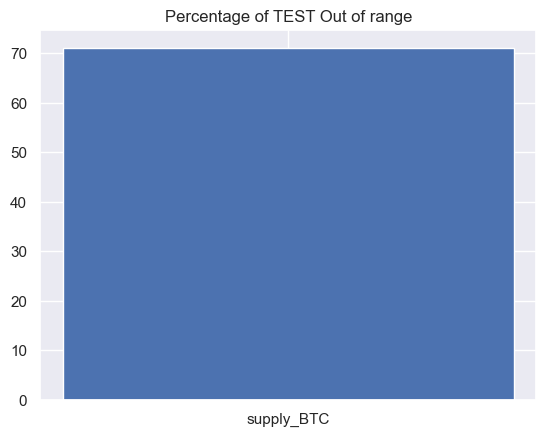

In [73]:
fig, ax = plt.subplots()
ax.bar(df_count_out.xs("pc_out_max").index.tolist(), df_count_out.xs("pc_out_max").values)
ax.bar(df_count_out.xs("pc_out_min").index.tolist(), -df_count_out.xs("pc_out_min").values)
ax.set_title("Percentage of TEST Out of range")

Text(0.5, 1.0, 'Features scaled boxplot')

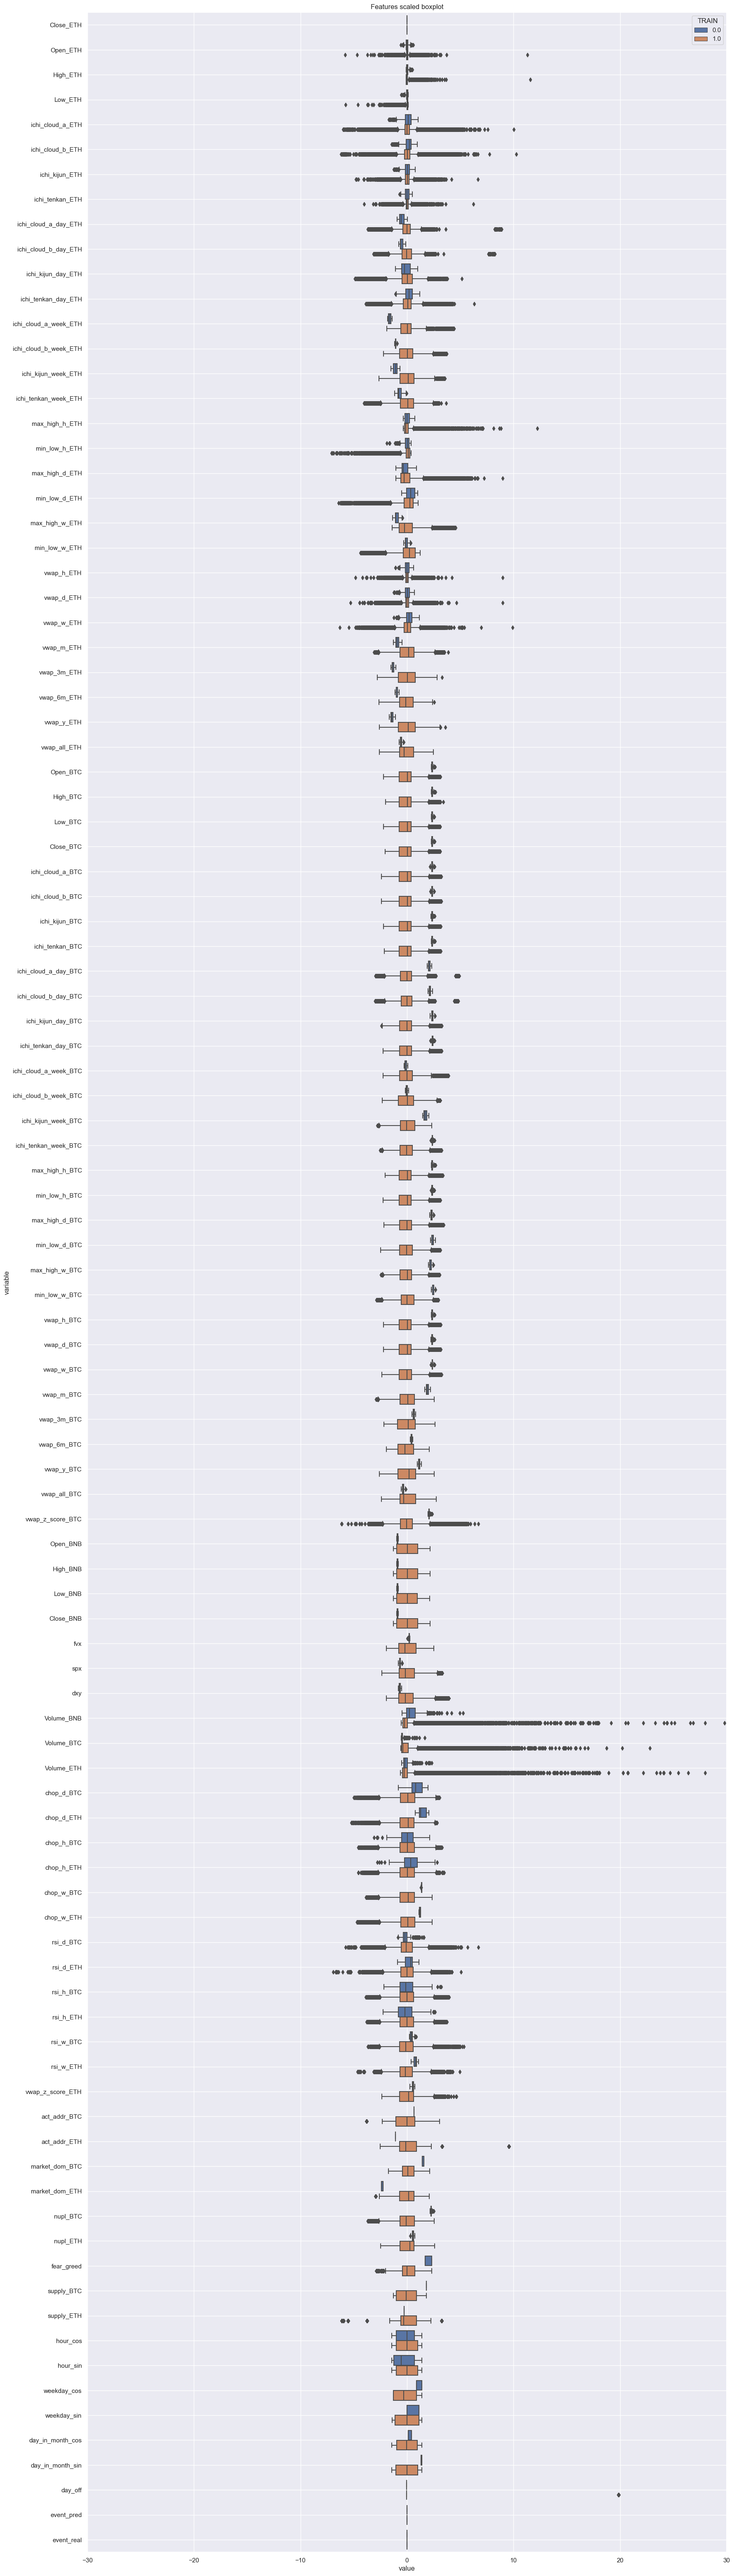

In [74]:
df_comp = df.melt(id_vars=["TRAIN"], value_vars=list_col_select, value_name="value")
plt.figure(figsize=(20, 80))
sns.boxplot(data=df_comp, x="value", y="variable" , hue="TRAIN")
fig = plt.gcf()
ax = fig.gca()
ax.set_xlim([-30,30])
ax.yaxis.grid(True)
plt.title("Features scaled boxplot")

In [75]:
df_comp[(df_comp["TRAIN"] == True) & (df_comp["variable"] == "day_off")]["value"].unique()

array([-0.05033869, 19.8654362 ])

In [76]:
df_comp[(df_comp["TRAIN"] == True) & (df_comp["variable"] == "day_off")]["value"].unique()


array([-0.05033869, 19.8654362 ])

In [77]:
df_comp[(df_comp["TRAIN"] == False) & (df_comp["variable"] == "day_off")]["value"].unique()

array([-0.05033869])

<Axes: >

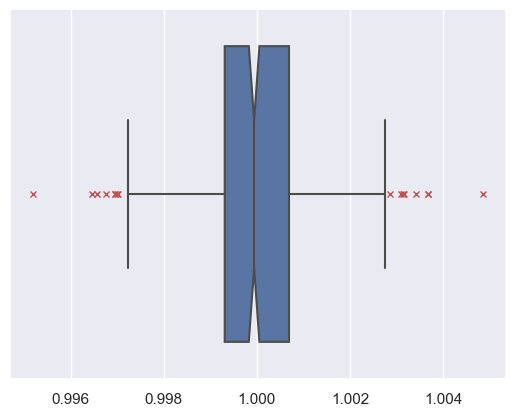

In [78]:
sns.boxplot(
    x=X_test[:,-1,:][:,1],  
    notch=True,
    flierprops={"markeredgecolor":"r", "marker": "x"}
)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


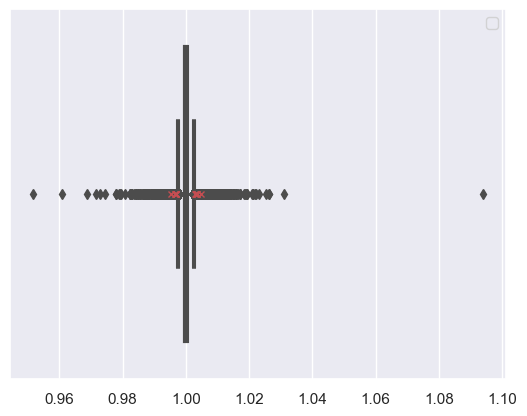

In [79]:
ax = sns.boxplot(
    x=X_train[:,-1,:][:,1],  
)
sns.boxplot(
    x=X_test[:,-1,:][:,1],  
    ax=ax, 
    flierprops={"markeredgecolor":"r", "marker": "x"},
)
plt.legend(loc='upper right')

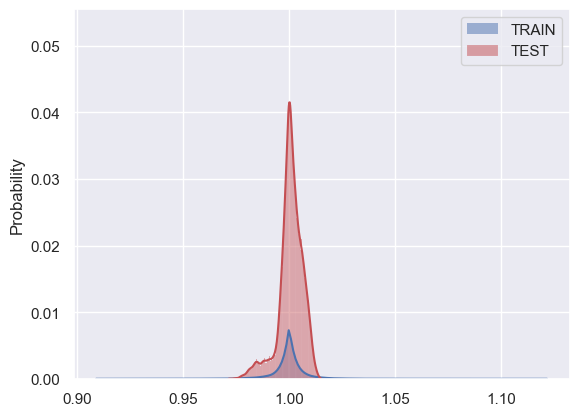

In [80]:

ax = sns.histplot(x=X_train.reshape(-1, X_train.shape[-1])[:,0],  stat="probability", kde=True, label="TRAIN")
sns.histplot(
    x=X_test.reshape(-1, X_test.shape[-1])[:,0],  
    stat="probability", 
    kde=True, 
    ax=ax, 
    color="r",
    label="TEST")
plt.legend(loc='upper right')

## Correlation

To simplify, we try to find correlation between all features X t-0 and target y t+1

In [81]:
X_train_sca.shape

(89018, 72, 102)

In [82]:
X_train_sca[:,-1,:].shape

(89018, 102)

In [83]:
y_train_sca[:,0][:, np.newaxis]

array([[ 0.10490539],
       [-0.03148941],
       [-0.20619073],
       ...,
       [-0.07600507],
       [ 0.14084547],
       [-0.36451262]])

In [84]:
np.hstack((X_train_sca[:,-1,:], y_train_sca[:,0][:, np.newaxis])).shape

(89018, 103)

In [85]:
list_col_select

['Close_ETH',
 'Open_ETH',
 'High_ETH',
 'Low_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'Open_BTC',
 'High_BTC',
 'Low_BTC',
 'Close_BTC',
 'ichi_cloud_a_BTC',
 'ichi_cloud_b_BTC',
 'ichi_kijun_BTC',
 'ichi_tenkan_BTC',
 'ichi_cloud_a_day_BTC',
 'ichi_cloud_b_day_BTC',
 'ichi_kijun_day_BTC',
 'ichi_tenkan_day_BTC',
 'ichi_cloud_a_week_BTC',
 'ichi_cloud_b_week_BTC',
 'ichi_kijun_week_BTC',
 'ichi_tenkan_week_BTC',
 'max_high_h_BTC',
 'min_low_h_BTC',
 'max_high_d_BTC',
 'min_low_d_BTC',
 'max_high_w_BTC',
 'min_low_

In [86]:
list_col_select

['Close_ETH',
 'Open_ETH',
 'High_ETH',
 'Low_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'Open_BTC',
 'High_BTC',
 'Low_BTC',
 'Close_BTC',
 'ichi_cloud_a_BTC',
 'ichi_cloud_b_BTC',
 'ichi_kijun_BTC',
 'ichi_tenkan_BTC',
 'ichi_cloud_a_day_BTC',
 'ichi_cloud_b_day_BTC',
 'ichi_kijun_day_BTC',
 'ichi_tenkan_day_BTC',
 'ichi_cloud_a_week_BTC',
 'ichi_cloud_b_week_BTC',
 'ichi_kijun_week_BTC',
 'ichi_tenkan_week_BTC',
 'max_high_h_BTC',
 'min_low_h_BTC',
 'max_high_d_BTC',
 'min_low_d_BTC',
 'max_high_w_BTC',
 'min_low_

In [87]:
def plot_corr(corr_matrix, title='Corrélation with 2 variables', aspect=None):
    # Afficher la matrice de corrélation
    if aspect is None:
        aspect = 1
    fig_size = (25, 25*len(corr_matrix.index)/len(corr_matrix.columns))
    fig, ax = plt.subplots(figsize=fig_size)
    im = ax.matshow(corr_matrix, aspect=aspect)
    plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=90)
    plt.yticks(range(len(corr_matrix.index)), corr_matrix.index)
    plt.title(title)
    fig.colorbar(im)
    plt.show()

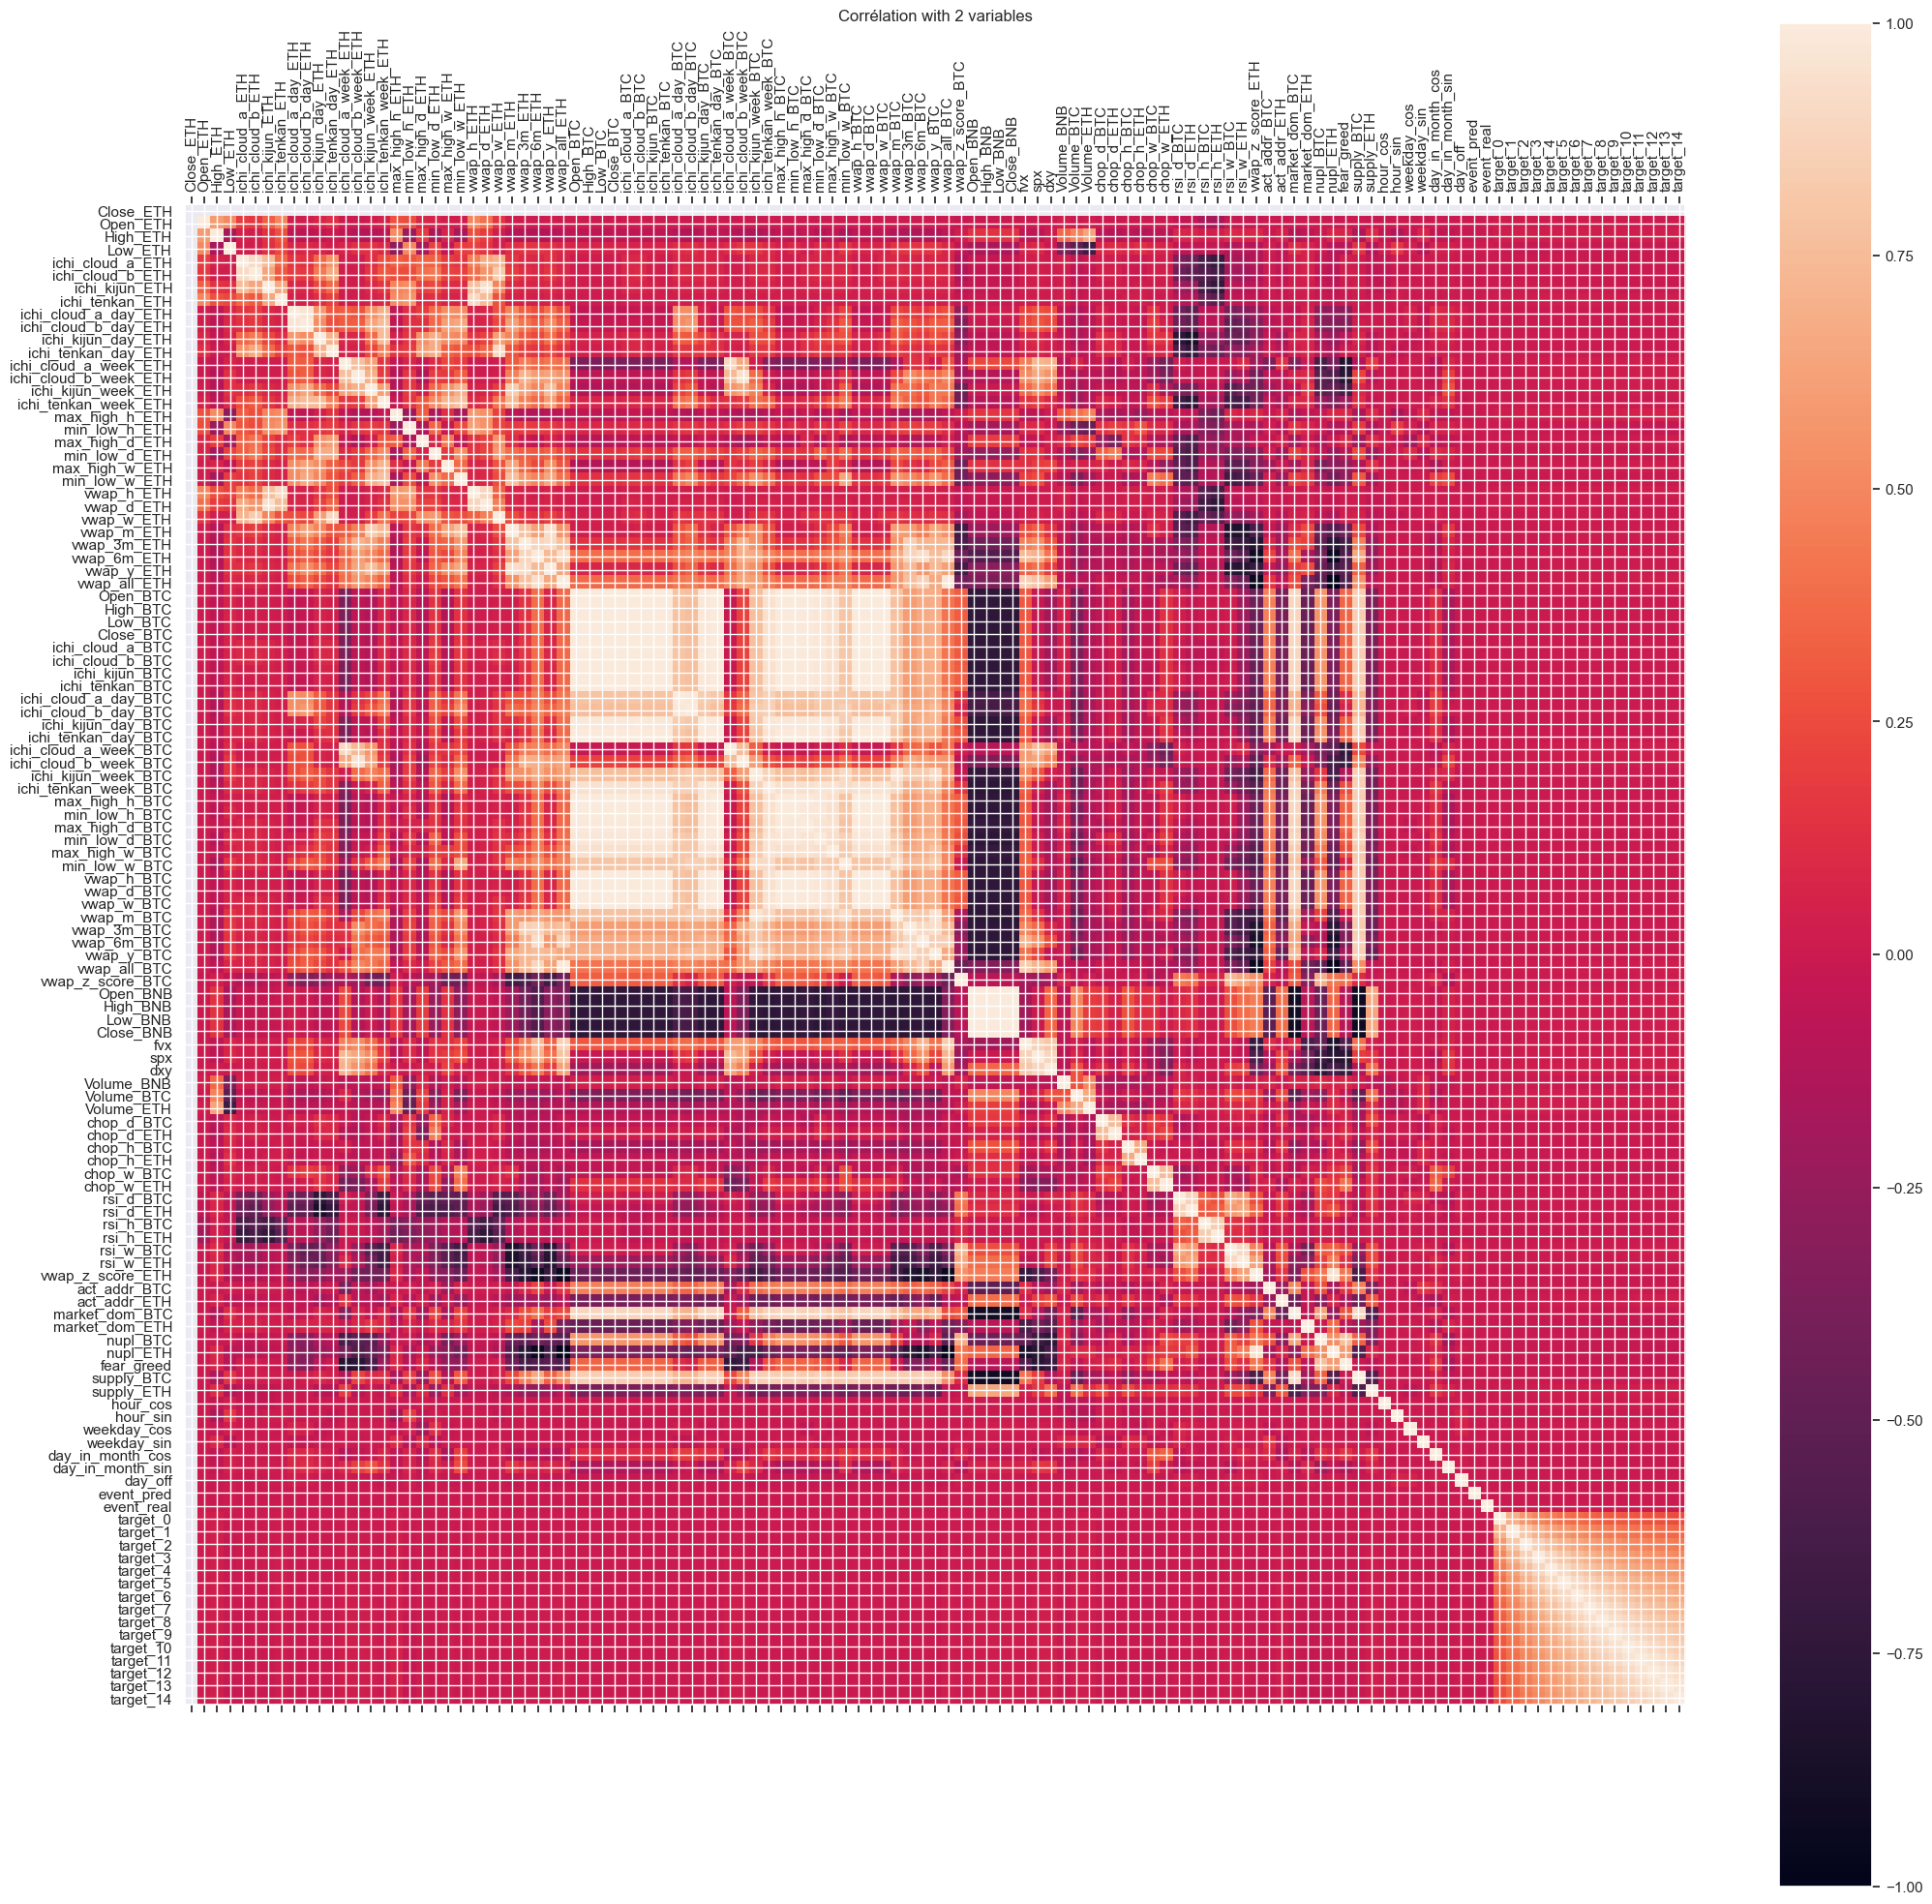

In [88]:

nb_plot = len(list_col_select)
list_col_targets = [ f"target_{n_t}" for n_t in range(FUTURE_TARGET)]
list_col_corr = list_col_select[:nb_plot] + list_col_targets

# Créer un DataFrame pandas à partir des données d'entrée X et de la variable à prédire y
#df = pd.DataFrame(np.hstack((X_train[:,-1,:nb_plot], y_train[:,0][:, np.newaxis])), 
#    columns=list_col_select[:nb_plot] + ['target'])
df = pd.DataFrame(np.hstack((X_train[:,-1,:nb_plot], y_train)), 
    columns=list_col_corr)
# Calculer la matrice de corrélation
corr_matrix = df.corr()

fig = plot_corr(corr_matrix)


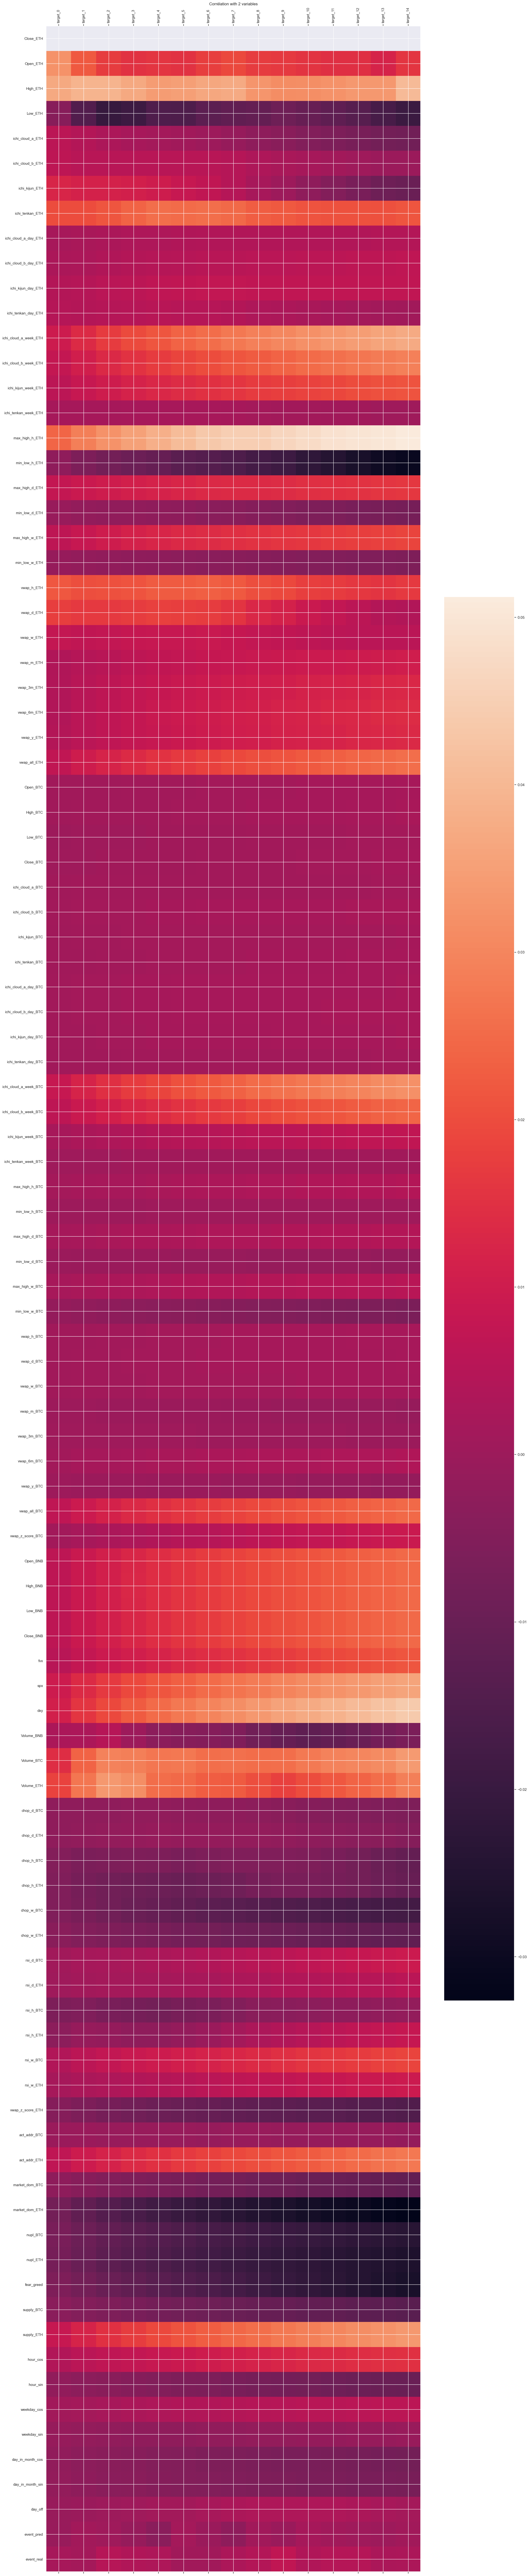

In [89]:
corr_matrix_targets = corr_matrix.copy().loc[list_col_select[:nb_plot], list_col_targets]
fig = plot_corr(corr_matrix_targets)


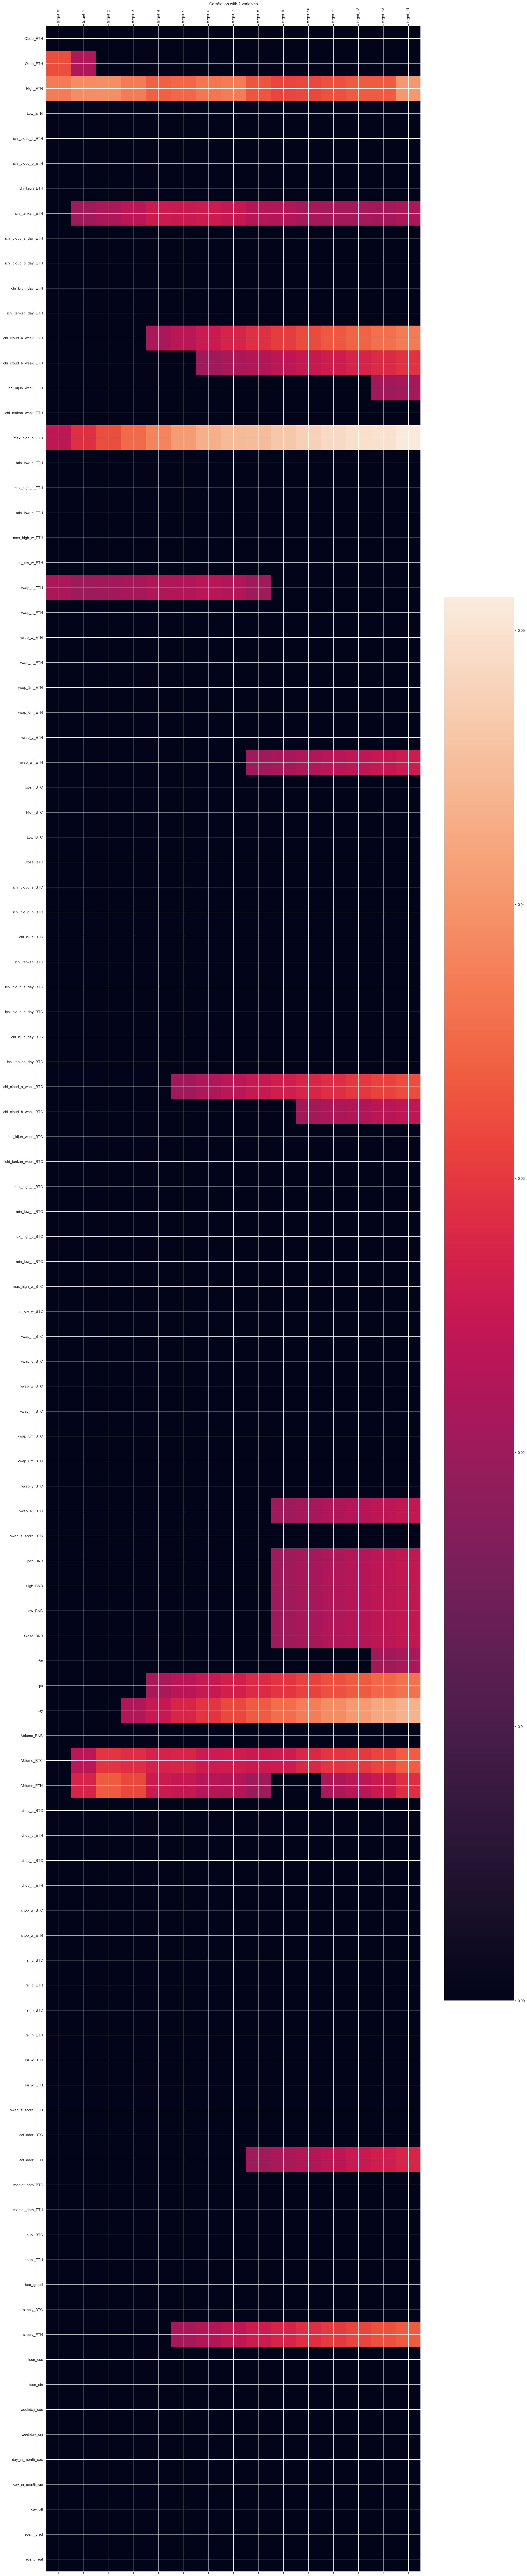

In [90]:
fig = plot_corr(corr_matrix_targets.where(corr_matrix_targets>0.02, 0))

In [91]:
list_ichi_level=["lower", "neutral", "higher"]
df["ichi_cloud_a_week_cat"] = "neutral"
df.loc[df["ichi_cloud_a_week_ETH"] >= 1.05, "ichi_cloud_a_week_cat"] = "lower"
df.loc[df["ichi_cloud_a_week_ETH"] <= 0.95, "ichi_cloud_a_week_cat"] = "higher"

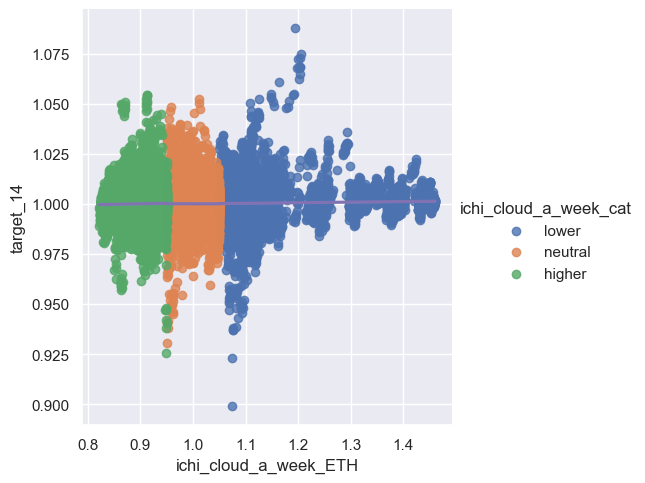

In [92]:
sns.lmplot(x="ichi_cloud_a_week_ETH", y="target_14",
            hue="ichi_cloud_a_week_cat", data=df,
           line_kws={"color": "C4"})

<Axes: xlabel='target_14', ylabel='ichi_cloud_a_week_cat'>

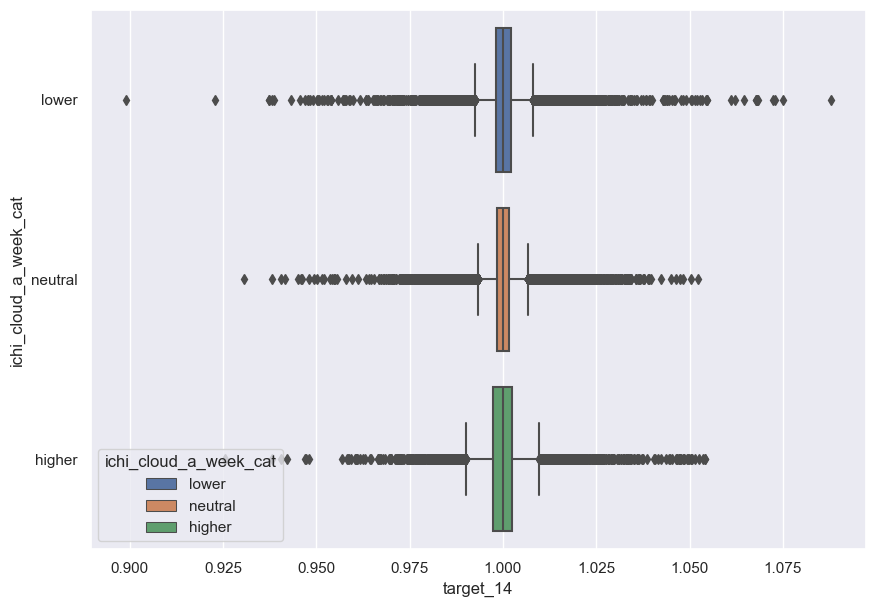

In [93]:
fig = plt.figure(figsize=(10, 7))
sns.boxplot(data=df, x="target_14", y="ichi_cloud_a_week_cat", 
    hue="ichi_cloud_a_week_cat", dodge=False, 
    order=list_ichi_level, hue_order=list_ichi_level)

In [94]:
"""df["vwap_all_ETH_under"] = df["vwap_all_ETH"] >= 1.05
df["vwap_all_ETH_above"] = df["vwap_all_ETH"] <= 0.95
df["vwap_all_ETH_neutral"] = ((df["vwap_all_ETH"] > 0.95) & (df["vwap_all_ETH"] < 1.05))
"""
list_vwap_level=["lower", "neutral", "higher"]
df["vwap_all_ETH_cat"] = "neutral"
df.loc[df["vwap_all_ETH"] >= 1.05, "vwap_all_ETH_cat"] = "lower"
df.loc[df["vwap_all_ETH"] <= 0.95, "vwap_all_ETH_cat"] = "higher"


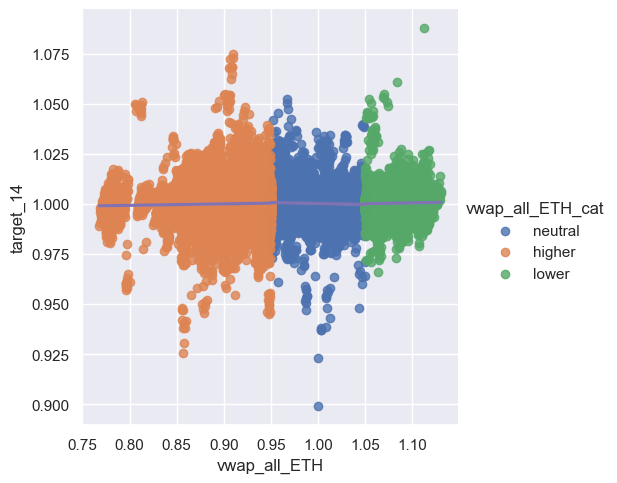

In [95]:
sns.lmplot(x="vwap_all_ETH", y="target_14", hue="vwap_all_ETH_cat", data=df,
           line_kws={"color": "C4"})

<Axes: xlabel='target_14', ylabel='vwap_all_ETH_cat'>

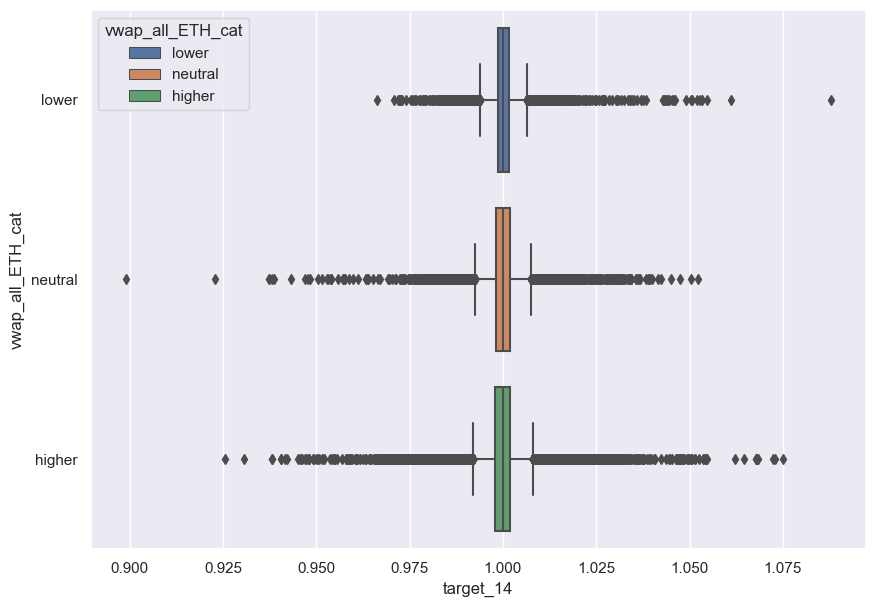

In [96]:
fig = plt.figure(figsize=(10, 7))
sns.boxplot(data=df, x="target_14", y="vwap_all_ETH_cat", 
    hue="vwap_all_ETH_cat", dodge=False, 
    order=list_vwap_level, hue_order=list_vwap_level)

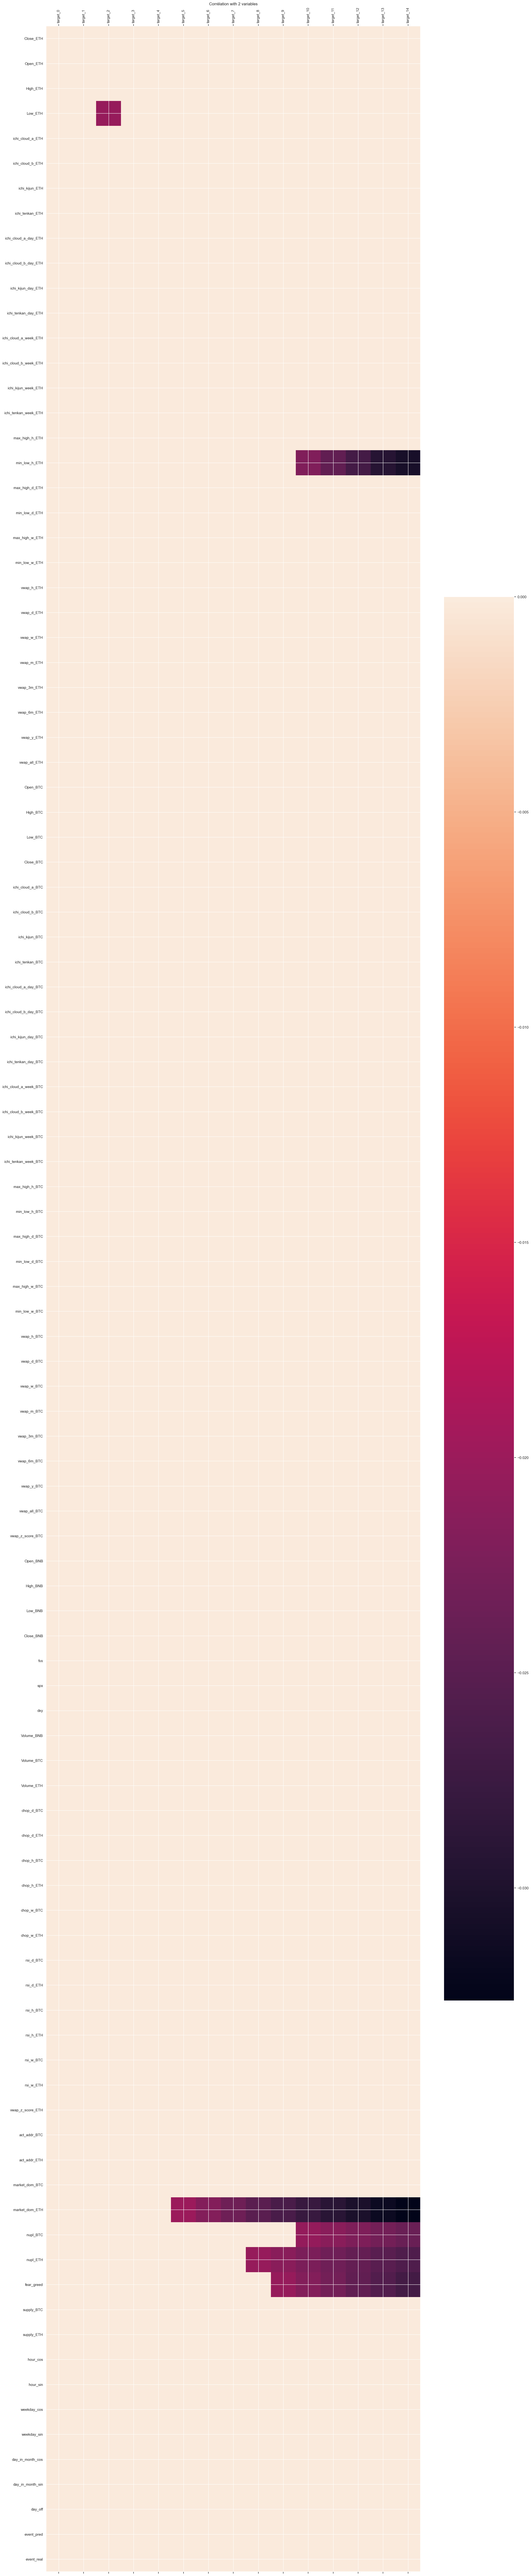

In [97]:
plot_corr(corr_matrix_targets.where(corr_matrix_targets<-0.02, 0))

Text(0.5, 1.0, 'Net Unrealized Profit/Loss impact : ETH price = f(NUPL)')

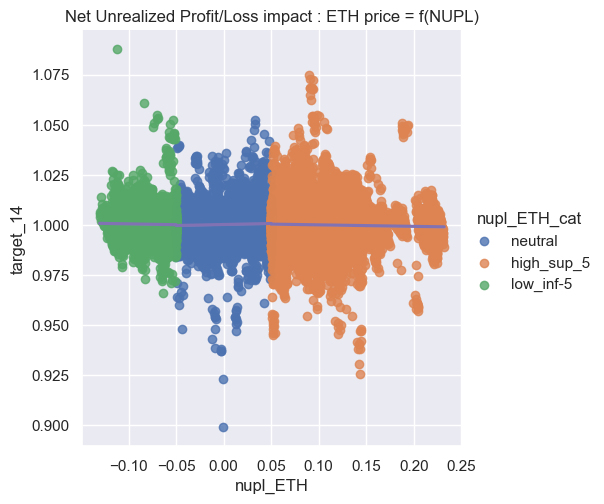

In [98]:
list_nupl_level=["low_inf-5", "neutral", "high_sup_5"]
df["nupl_ETH_cat"] = "neutral"
df.loc[df["nupl_ETH"] <= -0.05, "nupl_ETH_cat"] = "low_inf-5"
df.loc[df["nupl_ETH"] >= 0.05, "nupl_ETH_cat"] = "high_sup_5"

sns.lmplot(x="nupl_ETH", y="target_14", hue="nupl_ETH_cat", data=df,
           line_kws={"color": "C4"})
plt.title("Net Unrealized Profit/Loss impact : ETH price = f(NUPL)")

(0.98, 1.02)

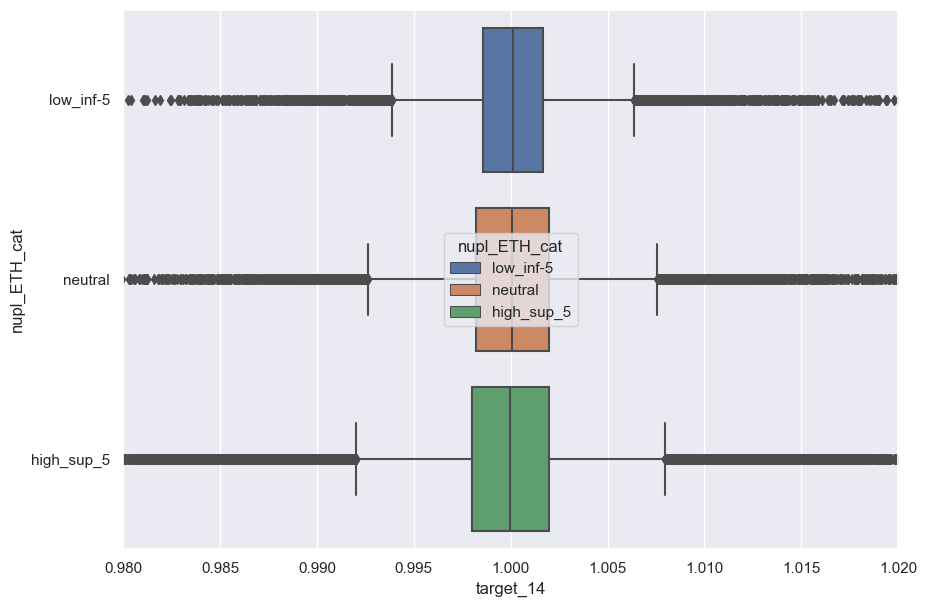

In [99]:
fig = plt.figure(figsize=(10, 7))
sns.boxplot(data=df, x="target_14", y="nupl_ETH_cat", 
    hue="nupl_ETH_cat", dodge=False, 
    order=list_nupl_level, hue_order=list_nupl_level)
ax = fig.gca()
ax.set_xlim([0.98,1.02])

In [100]:
df["target_14"].describe()

count    89018.000000
mean         1.000091
std          0.005348
min          0.899006
25%          0.998152
50%          1.000021
75%          1.001930
max          1.087790
Name: target_14, dtype: float64

In [101]:
df["target_1"].describe()

count    89018.000000
mean         1.000012
std          0.001995
min          0.907143
25%          0.999284
50%          1.000005
75%          1.000740
max          1.053076
Name: target_1, dtype: float64

<Axes: xlabel='target_14'>

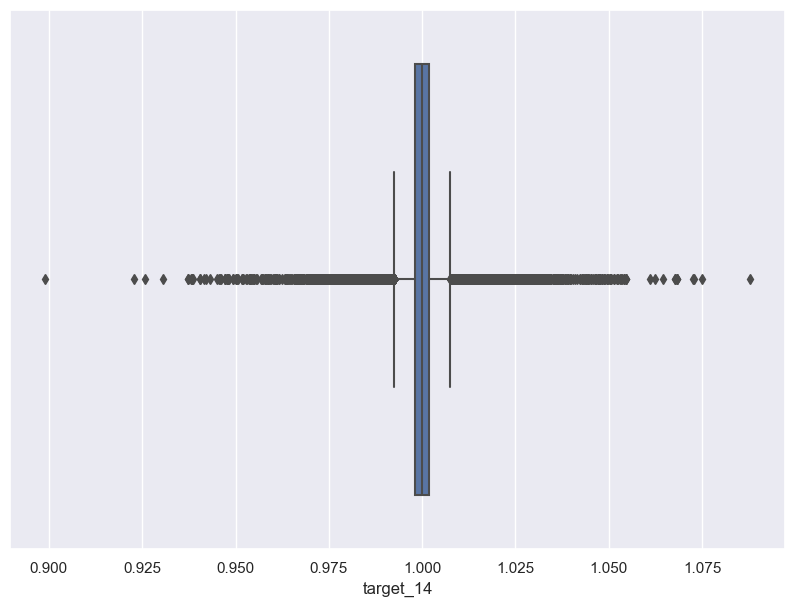

In [102]:
fig = plt.figure(figsize=(10, 7))
sns.boxplot(x=df["target_14"]) 

In [103]:
y_train

array([[1.00046043, 1.00038509, 0.99962329, ..., 0.99989117, 1.00015069,
        0.99985769],
       [0.99992469, 0.99916324, 0.99983265, ..., 0.9996904 , 0.99939753,
        0.99880344],
       [0.99923849, 0.99990795, 0.99943096, ..., 0.9994728 , 0.99887866,
        0.99859414],
       ...,
       [0.99974984, 1.00035129, 0.99896743, ..., 1.00327867, 1.00309238,
        1.00373641],
       [1.0006016 , 0.99921739, 0.99873825, ..., 1.00334338, 1.00398756,
        1.00522802],
       [0.99861663, 0.99813777, 0.99680229, ..., 1.00338393, 1.00462364,
        1.0031179 ]])

In [104]:
y_train_sca

array([[ 0.10490539,  0.08572363, -0.10822528, ..., -0.04002346,
         0.02604704, -0.04854869],
       [-0.03148941, -0.22534906, -0.05492299, ..., -0.09113853,
        -0.16569994, -0.31695307],
       [-0.20619073, -0.03575183, -0.15718954, ..., -0.14653711,
        -0.29780164, -0.37023817],
       ...,
       [-0.07600507,  0.07711857, -0.2752013 , ...,  0.8224106 ,
         0.77498292,  0.93894717],
       [ 0.14084547, -0.21156255, -0.33354995, ...,  0.83888445,
         1.00288972,  1.31870153],
       [-0.36451262, -0.48642667, -0.82643142, ...,  0.84920948,
         1.16483141,  0.78147945]])

In [105]:
X_train_sca.shape

(89018, 72, 102)

In [106]:
X_test_sca.shape

(360, 72, 102)

In [107]:
#np.save('array_3d.npy', X_train_sca) 
#np.savez_compressed('arrays_compressed.npz', array_3d=X_train_sca)